# Two high-level analyses:
- Predict performance (accuracy) using a regression
- Classify users into 'bad' vs 'good'--still need to define this but perhaps the threshold is any user < 70% and any user >= 70%

For github issues and brainstorming features and analyses, use github:
- https://github.com/ProjectSidewalk/sidewalk-quality-analysis/issues

# Table of Content
1. Imports, file creation, list creations
2. Graph Visualizations
3. Features for ML Model Creation
4. Dataframe for ML Model Creation
5. ML Model Creation
6. Creates Label Accuracy Files
7. CV
8. Accuracy by Label Type
9. Feature Comparisons
10. High School Student
11. DC Data

# Imports, file creation, list creations

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from dateutil import parser as parser
import csv
from sklearn import svm
import sklearn.feature_selection
from sklearn.feature_selection import SelectFromModel
from sklearn import tree
from sklearn.ensemble import ExtraTreesClassifier, ExtraTreesRegressor
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.neural_network import MLPClassifier
from sklearn.neural_network import MLPRegressor
from sklearn import linear_model
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import VarianceThreshold
import requests
import json
import scipy
import classifier

In [3]:
# Loads all of the data that we need
users_old = pd.read_csv('ml-users.csv')
users = pd.read_csv('users_one_mission.csv')
# users = pd.read_csv('cv-accuracy.csv')
labels = pd.read_csv('ml-label-correctness-one-mission.csv')
grouped_labels = labels.groupby('user_id')
logins = pd.read_csv('seattle-login-counts.csv')
sessions = pd.read_csv('seattle-session-counts.csv')
users['logins'] = logins['count']
users['sessions'] = sessions['n_sessions']

In [218]:
# Keep the user that meet a certain criteria to analyze
to_remove = []
for index, current in enumerate(users['labels_validated']):
    if current < 16:
        to_remove.append(index)
users.drop(users.index[to_remove], inplace=True)
users = users.reset_index(drop = True)

In [220]:
# Keeps logins and sessions for users we are analyzing
to_remove = []
for index, current in enumerate(logins['user_id']):
    if current not in users.values:
        to_remove.append(index)
logins.drop(logins.index[to_remove], inplace=True)
logins = logins.reset_index(drop = True)
to_remove = []
for index, current in enumerate(sessions['user_id']):
    if current not in users.values:
        to_remove.append(index)
sessions.drop(sessions.index[to_remove], inplace=True)
sessions = sessions.reset_index(drop = True)

In [77]:
# Users w/ accuracies below 65% and are not in neighorhoods without sidewalks from the
# Initial 29 by manually going through and 
overall_bad_users = ['1353d168-ab49-4474-ae8a-213eb2dafab5', '35872a6c-d171-40d9-8e66-9242b835ea71',
                     '6809bd6e-605f-4861-bc49-32e52c88c675', '939b6faa-0b57-4160-bcc2-d11fd2b69d9f',
                      'f5314ef9-3877-438c-ba65-ee2a2bbbf7f5']

In [78]:
# high school student on Project Sidewalk as community service
hs_users = ['d2b04e27-13ce-4aff-a06a-7c7147c96696']

In [5]:
# Lists of all the tags belonging to each label type
curb_ramp_tags = ['narrow', 'points into traffic', 'missing friction strip', 'steep', 'not enough landing space']
obstacle_tags = ['fire hydrant', 'pole', 'tree', 'vegetation', 'trash/recycling can', 'parked car', 'parked bike']
missing_curb_ramp_tags = ['alternate route present', 'no alternate route', 'unclear if needed']
surface_problem_tags = ['bumpy', 'uneven', 'cracks', 'grass', 'narrow sidewalk']
no_sidewalk_tags = ['ends abruptly', 'street has a sidewalk', 'street has no sidewalks']
other_tags = ['missing crosswalk', 'no bus stop access']

In [4]:
# parses through each user's csv and figures out how many unique panos and missions seen
# This is used to normalize the data to be by per missions or per pano
user_panos = {}
user_missions = {}
for current_user in users['user_id']:
    df_current = pd.read_csv('{0}_new.csv'.format(current_user))
    user_panos[current_user] = df_current['gsv_panorama_id'].nunique()
    user_missions[current_user] = df_current['mission_id'].nunique()

In [8]:
missions_started = ['missions started']
df_user_panos = pd.DataFrame(list(user_missions.values()), columns = missions_started, index = user_missions.keys())
df_user_panos.to_csv('missions_started.csv', encoding='utf-8', index=True)

In [289]:
panos_seen = ['panos seen']
df_user_panos = pd.DataFrame(list(user_panos.values()), columns = panos_seen, index = user_panos.keys())
df_user_panos.to_csv('panos_seen.csv', encoding='utf-8', index=True)

In [15]:
# Takes in the row and appends the row into the given file
def file_appender(row, created, user_info):
    if user_info not in created:
        with open('{0}_new.csv'.format(user_info), 'w', newline = '') as new_user:
            writer = csv.writer(new_user)
            created.append(user_info)
            writer.writerow(header)
    with open('{0}_new.csv'.format(user_info), 'a', newline = '') as edit_user:
        editor = csv.writer(edit_user)
        editor.writerow(row)
    return created

In [16]:
# Parses through the csv and creates new csv for every user & action
# This is needed to be able to avoid storing all of the interaction information as a variable
# These csv files will be referenced in future analysis
with open('dc-all-interactions.csv', newline = '') as data:
    reader = csv.reader(data)
    header = []
    users_created = []
    events_created = []
    for row in reader:
        if row[1] == 'user_id':
            header = row
        else:
            user_id = row[1]
            current_event = row[4]
            users_created = file_appender(row, users_created, user_id)
            events_created = file_appender(row, events_created, current_event)

In [ ]:
# Takes all label data from a csv and creates csv of each user's calculated label data
#  Including number of correct and false labels, total labels and number of validated labels
user_labels = {}
labels_grouped = labels.groupby('user_id')
for current_id, current_group in labels_grouped:
    total = len(current_group)
    accuracy = 0
    correct = sum(current_group['correct'] == 't')
    false = sum(current_group['correct'] == 'f')
    validated = correct + false
    if validated != 0:
        accuracy = float(correct) / float(validated) * 100
    missions_completed = user_missions[current_id]
    user_labels[current_id] = current_id, total, validated, correct, false,  accuracy, missions_completed
header = ['user_id', 'total_labels', 'labels_validated', 'correct_labels', 'false_labels', 'accuracy', 'missions_completed']
with open('users_one_mission.csv', 'w', newline = '') as new_user:
    writer = csv.writer(new_user)
    writer.writerow(header)
for user in user_labels.values():
    with open('users_one_mission.csv', 'a', newline = '') as edit_user:
        editor = csv.writer(edit_user)
        editor.writerow(user)

In [ ]:
# Created a csv file of all of the No Sidewalk labels
with open('LabelingCanvas_FinishLabeling.csv', newline = '') as data:
    reader = csv.reader(data)
    for index, row in enumerate(reader):
        if row[1] == 'user_id':
            header = row
        else:
            if index == 0:
                with open('All_Nosidewalk_labels.csv', 'w', newline = '') as new_user:
                        writer = csv.writer(new_user)
                        writer.writerow(header)
            else:
                with open('All_Nosidewalk_labels.csv', 'a', newline = '') as edit_user:
                    editor = csv.writer(edit_user)
                    if 'NoSidewalk' in row[11]:
                        editor.writerow(row)

# Graph Visualizations

In [252]:
# Counting the number of tags placed of a certain type
# The notes section of each tag add action is ready to find the expected grpahs
# tag_type_heading is the name of the tag to be used in the graph. 
# tag_type_kinds is the list containing all of the tags of a certain label type
# tag_type is the type that is logged in the interactions. 
def tag_counter(tag_type_heading, tag_type_kinds, tag_type):
    user_information = {}
    df_information = pd.read_csv('ContextMenu_TagAdded.csv')
    df_grouped = df_information.groupby(['user_id'])
    for current, group in df_grouped:
        users_index = (users['user_id'] == current).idxmax()
        tags_count = 0
        for current_index, current_type in enumerate(group['note']):
            beginning_length = current_type.find('tagName:') + 8 
            ending_length = 13 + len(str(group['audit_task_id'].iloc[current_index]))
            if current_type[beginning_length:-ending_length] in tag_type_kinds:
                tags_count += 1
        current_accuracy = users['accuracy'][users_index]
        if tag_type != None:
            current_accuracy = label_type_accuracy[current, tag_type] * 100
        user_information[current] = tags_count, current_accuracy, users['accuracy'][users_index]
    for index, current_user in enumerate(users['user_id']):
        if current_user not in user_information:
            user_information[current_user] = 0, users['accuracy'][index], users['accuracy'][users_index]
    tag_scatter_plot(tag_type_heading, user_information)

In [260]:
# Used to create a correlation between accuracy and the info type that was given
# It accepts a string for the actions that will be used to record the info type
# graph_type determines how the information is shown and multi_plot determines if it can
# be shows in per panos & per mission.
def counting_graph (info_type, graph_type, multi_plot, action):
    user_information = {}
    df_information = pd.read_csv('{0}.csv'.format(action))
    df_actions_grouped = df_information.groupby(['user_id'])
    for index, current_id in enumerate(df_actions_grouped.groups):
        users_index = (users['user_id'] == current_id).idxmax()
        user_information[current_id] = len(df_actions_grouped.get_group(current_id)), users['accuracy'][users_index], current_id
    for index, current_user in enumerate(users['user_id']):
        if current_user not in user_information:
            user_information[current_user] = 0, users['accuracy'][index], current_user
    if graph_type == 'scatter_plot':
        scatter_plot(info_type, user_information, multi_plot)
    elif graph_type == 'histogram':
        histogram(info_type, user_information)

In [274]:
# Creates a scatter plot of the information given, if multi_plot is true then it is also
# divided by the number of unique panos seens and missions started
# Plots a trend line too
def scatter_plot(info_type, user_information, multi_plot):
    if multi_plot:
        user_information_pano = []
        user_information_mission = []
        f, axs = plt.subplots(1,3,figsize=(12,4))
        plt.subplot(133)
        plt.ylabel('User Accuracy')
        plt.xlabel(info_type + ' per Pano')
        for entry in user_information.keys():
            if entry in user_panos:
                user_info = user_information.get(entry)
                info = float(user_info[0]) / float(user_panos[entry])
                accuracy = user_info[1]
                current_user_id = user_info[2]
                user_information_pano.append([info,accuracy])
                if entry in overall_bad_users: 
    #             if accuracy < 65:
                    plt.plot(info, accuracy, '.', color = 'red')
                elif entry in hs_users:
                    plt.plot(info, accuracy, '.', color = 'green')
                elif accuracy < 65:
                    plt.plot(info, accuracy, '.', color = 'black')
                else:
                    plt.plot(info, accuracy, '.', color = 'blue')
        temp = np.array(user_information_pano)
        z = np.polyfit(temp[:,0],temp[:,1],1)
        w = np.poly1d(z)
        pears= scipy.stats.pearsonr(temp[:,1], w(temp[:,0]))
        plt.plot(temp[:,0],w(temp[:,0]))
        plt.legend(['R =' + str(f'{pears[0]:.2f}')])
        plt.subplot(132)
        plt.ylabel('User Accuracy')
        plt.xlabel(info_type + ' per Mission Started')
        for entry in user_information.keys():
            if entry in user_missions:
                user_info = user_information.get(entry)
                info = float(user_info[0]) / float(user_missions[entry])
                accuracy = user_info[1]
                user_information_mission.append([info,accuracy])
                if entry in overall_bad_users: 
    #             if accuracy < 65:
                    plt.plot(info, accuracy, '.', color = 'red')
                elif entry in hs_users:
                    plt.plot(info, accuracy, '.', color = 'green')
                elif accuracy < 65:
                    plt.plot(info, accuracy, '.', color = 'black')
                else:
                    plt.plot(info, accuracy, '.', color = 'blue')
        temp = np.array(user_information_mission)
        z = np.polyfit(temp[:,0],temp[:,1],1)
        w = np.poly1d(z)
        pears= scipy.stats.pearsonr(temp[:,1], w(temp[:,0]))
        plt.plot(temp[:,0],w(temp[:,0]))
        plt.legend(['R =' + str(f'{pears[0]:.2f}')])
        plt.subplot(131)
    plt.ylabel('User Accuracy')
    plt.xlabel(info_type)
    for entry in user_information.keys():
        user_info = user_information.get(entry)
        info = user_info[0]
        accuracy = user_info[1]
        if entry in overall_bad_users:
#         if accuracy > 65:
            plt.plot(info, accuracy, '.', color = 'red')
        elif entry in hs_users:
                    plt.plot(info, accuracy, '.', color = 'green')
        elif accuracy < 65:
                plt.plot(info, accuracy, '.', color = 'black')
        else:
            plt.plot(info, accuracy, '.', color = 'blue')
    temp = np.array(list(user_information.values()))
    z = np.polyfit(temp[:,0],temp[:,1],1)
    w = np.poly1d(z)
    pears= scipy.stats.pearsonr(temp[:,1], w(temp[:,0]))
    plt.plot(temp[:,0],w(temp[:,0]))
    plt.legend(['R =' + str(f'{pears[0]:.2f}')])

In [255]:
# Creates a scatter plot based off of the accuracy of a specific tag type but colors by
# overall accuracy
def tag_scatter_plot(info_type, user_information):
    plt.ylabel('User Accuracy')
    plt.xlabel(info_type)
    for entry in user_information.keys():
        user_info = user_information.get(entry)
        info = user_info[0]
        accuracy = user_info[1]
        total_accuracy = user_info[2]
        if entry in overall_bad_users:
#         if accuracy > 65:
            plt.plot(info, accuracy, '.', color = 'red')
        elif total_accuracy < 65:
                plt.plot(info, accuracy, '.', color = 'black')
        else:
            plt.plot(info, accuracy, '.', color = 'blue')
    temp = np.array(list(user_information.values()))
    z = np.polyfit(temp[:,0],temp[:,1],1)
    w = np.poly1d(z)
    pears= scipy.stats.pearsonr(temp[:,1], w(temp[:,0]))
    plt.plot(temp[:,0],w(temp[:,0]))
    plt.legend(['R =' + str(f'{pears[0]:.2f}')])

In [256]:
#Creates a histogram counting the occurances of a certain type of information
def histogram(info_type, user_information):
    plt.hist(user_information)
    plt.xlabel(info_type)
    plt.ylabel('Count')

In [284]:
# Counts the number of keyboard presses
counting_graph('Keyboard Presses', 'scatter_plot', True, 'LowLevelEvent_keydown_old')

TypeError: ufunc 'add' did not contain a loop with signature matching types dtype('<U36') dtype('<U36') dtype('<U36')

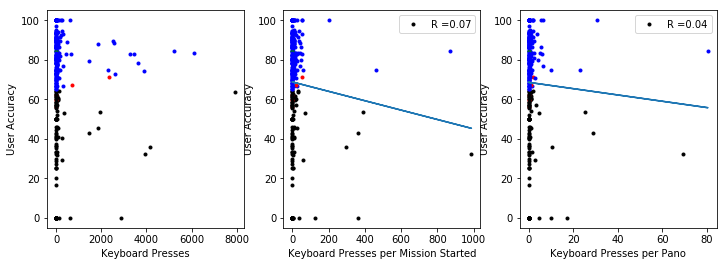

In [275]:
# Counts the number of keyboard presses
counting_graph('Keyboard Presses', 'scatter_plot', True, 'LowLevelEvent_keydown_new')

In [ ]:
# Counts the number of mouse clicks
counting_graph('Mouse Clicks', 'scatter_plot', True, 'LowLevelEvent_mousedown_old')

TypeError: ufunc 'add' did not contain a loop with signature matching types dtype('<U36') dtype('<U36') dtype('<U36')

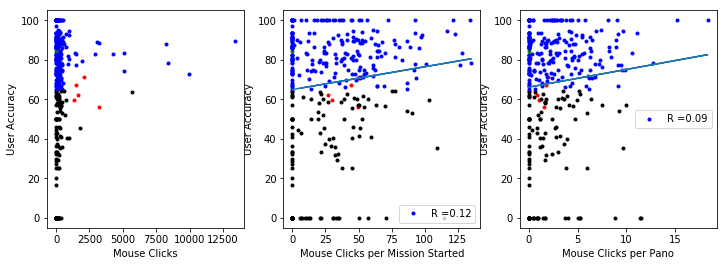

In [276]:
# Counts the number of mouse clicks
counting_graph('Mouse Clicks', 'scatter_plot', True, 'LowLevelEvent_mousedown_new')

In [ ]:
# Counts the number of missions completed
counting_graph('Missions Completed', 'scatter_plot', False, 'MissionComplete_old')

In [ ]:
# Counts the number of missions completed
counting_graph('Missions Completed', 'scatter_plot', False, 'MissionComplete')

In [ ]:
# Counts the number of zooms
counting_graph('Zooms', 'scatter_plot', True, 'Click_ZoomIn')

In [ ]:
# Counts the number of Labels Deleted
counting_graph('Label deleted', 'scatter_plot', True, 'RemoveLabel')

In [229]:
# Counts the total number of Tags Placed
counting_graph('Tag Added', 'scatter_plot', True, 'ContextMenu_TagAdded')

In [230]:
# number of curb ramp label tags compared to curb ramp accuracy
tag_counter('Curb Ramp Tags', curb_ramp_tags, 'CurbRamp')

In [231]:
# Number of missing curb ramp label tags compared to missing curb ramp accuracy
tag_counter('MissingCurb Ramp Tags', missing_curb_ramp_tags, 'NoCurbRamp')

In [232]:
# number of obstacle label tags compared to obstacle accuracy
tag_counter('Obstacle Tags', obstacle_tags, 'Obstacle')

In [233]:
# number of surface problem label tags compared to surface problem accuracy
tag_counter('Surface Problem Tags', surface_problem_tags, 'SurfaceProblem')

In [234]:
# Number of no sidewalk label tags compared to user accuracy
tag_counter('No Sidewalk Tags', no_sidewalk_tags, None)

In [235]:
# Counts the number of Label Confirmation based off of closing the context window
counting_graph('Label Confirmations', 'scatter_plot', True, 'LabelingCanvas_FinishLabeling')

In [236]:
# Counts the number of mouse movements
counting_graph('Mouse Movement', 'scatter_plot', True, 'LowLevelEvent_mousemove')

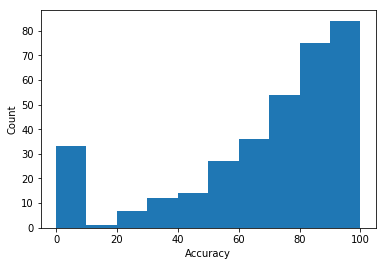

In [127]:
# Counts the number of users with different accuracies
histogram('Accuracy', users['accuracy'])

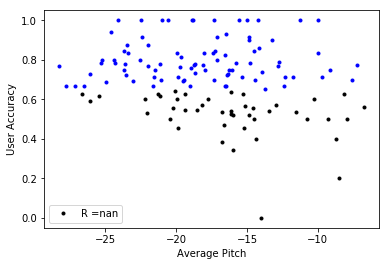

In [89]:
# Finds the average pitch, how far up or down vertically the user is usally looking
user_information = {}
for index, current_id in enumerate(users['worker1']):
    df_current_user = pd.read_csv('{0}.csv'.format(current_id))
    user_information[current_id] = df_current_user['pitch'].mean(), users['precision'][index]
scatter_plot('Average Pitch', user_information, False)

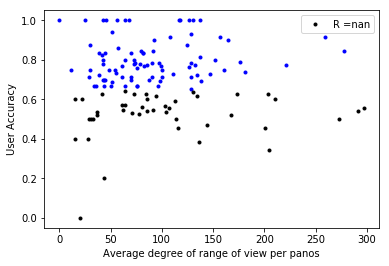

In [117]:
# Calculates the average range of how much a person looks looks side to side horizontally
user_information = {}
for index, current_id in enumerate(users['worker1']):
    df_current_user = pd.read_csv('{0}.csv'.format(current_id))
    df_grouped = df_current_user.groupby(['gsv_panorama_id'])
    current_heading = []
    for current, group in df_grouped:
        range = group['heading'].max() - group['heading'].min()
        current_heading.append(range)
        user_information[current_id] = (sum(current_heading) / float(len(current_heading))),users['precision'][index]
scatter_plot('Average degree of range of view per panos', user_information, False)

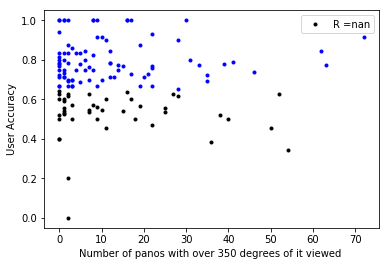

In [124]:
# Counts the number of times a user looks atleast 350 degrees of a pano per pano seen
user_information = {}
for index, current_id in enumerate(users['worker1']):
    df_current_user = pd.read_csv('{0}.csv'.format(current_id))
    df_grouped = df_current_user.groupby(['gsv_panorama_id'])
    full_heading_count = 0
    for current, group in df_grouped:
        range = group['heading'].max() - group['heading'].min()
        if range >= 350:
            full_heading_count += 1
    user_information[current_id] = float(full_heading_count) / float(user_panos[current_id]), users['precision'][index]
scatter_plot('Number of panos with over 350 degrees of it viewed per pano ', user_information, False)

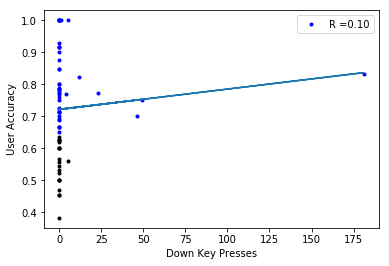

In [123]:
# Number of times the down key is pressed
user_information = {}
df_information = pd.read_csv('LowLevelEvent_keydown_dc.csv')
df_grouped = df_information.groupby(['user_id'])
for current, group in df_grouped:
    users_index = (users['worker1'] == current).idxmax()
    count = sum(group['note'].str.count('keyCode:40'))
    user_information[current] = count , users['precision'][users_index]
scatter_plot('Down Key Presses', user_information, False)

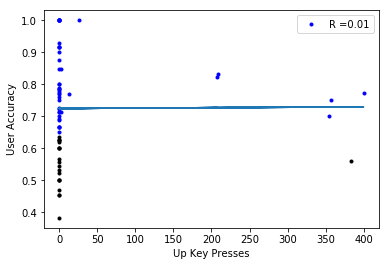

In [125]:
# Number of times the up key is pressed
user_information = {}
df_information = pd.read_csv('LowLevelEvent_keydown.csv')
df_grouped = df_information.groupby(['user_id'])
for current, group in df_grouped:
    users_index = (users['worker1'] == current).idxmax()
    count = sum(group['note'].str.count('keyCode:38'))
    user_information[current] = count , users['precision'][users_index]
scatter_plot('Up Key Presses', user_information, False)

In [129]:
# Counts the number of times a user goes back to a pano they've already been in during the
# same mission
user_information = {}
df_information = pd.read_csv('PanoId_Changed.csv')
df_grouped = df_information.groupby(['user_id'])
for current, group in df_grouped:
    users_index = (users['user_id'] == current).idxmax()
    mission_id = 0
    current_user_duplicates = 0
    total_user_duplicates = 0
    current_panos_seen = []
    for index, current_pano in enumerate(group['gsv_panorama_id']):
        current_mission = group['mission_id'].iloc[index]
        if current_mission != mission_id:
            total_user_duplicates += current_user_duplicates
            current_user_duplicates = 0
            current_panos_seen = [current_pano]
            mission_id = current_mission
        else:
            if current_pano in current_panos_seen:
                current_user_duplicates += 1
            else:
                current_panos_seen.append(current_pano)
    user_information[current] = total_user_duplicates, users['precision'][users_index]
scatter_plot('Panos revisited', user_information, False)

In [128]:
#  Calculates the average length of comments
user_information = {}
df_information = pd.read_csv('ContextMenu_TextBoxChange.csv')
df_grouped = df_information.groupby(['user_id'])
for current, group in df_grouped:
    users_index = (users['worker1'] == current).idxmax()
    comment_length_total = 0
    comment_count = 0
    for index, current_comment in enumerate(group['note']):
        audit_task_id = group['audit_task_id'].iloc[index]
        end_length = len(str(audit_task_id)) + 13
        current_comment = current_comment[11:-end_length]
        comment_count += 1
        comment_length_total += len(current_comment)
    user_information[current] = float(comment_length_total) / comment_count, users['precision'][users_index]
for index, current_user in enumerate(users['worker1']):
    if current_user not in user_information:
        user_information[current_user] = 0, users['precision'][index]
scatter_plot('Average Comment Length', user_information, False)

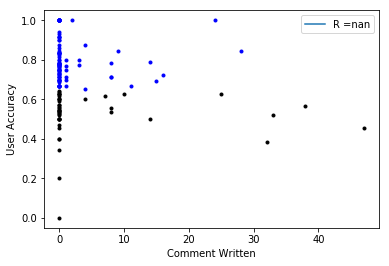

In [133]:
# Counts the number of Comments Written
user_information = {}
df_information = pd.read_csv('ContextMenu_TextBoxChange.csv')
df_grouped = df_information.groupby(['user_id'])
for index, current_id in enumerate(df_grouped.groups):
    users_index = (users['worker1'] == current_id).idxmax()
    user_information[current_id] = len(df_grouped.get_group(current_id)), users['precision'][users_index]
for index, current_user in enumerate(users['worker1']):
    if current_user not in user_information:
        user_information[current_user] = 0, users['precision'][index]
temp = np.array(list(user_information.values()))
z = np.polyfit(temp[:,0],temp[:,1],1)
w = np.poly1d(z)
pears= scipy.stats.pearsonr(temp[:,1], w(temp[:,0]))
plt.plot(temp[:,0],w(temp[:,0]))
plt.legend(['R =' + str(f'{pears[0]:.2f}')])
scatter_plot('Comment Written', user_information, False)

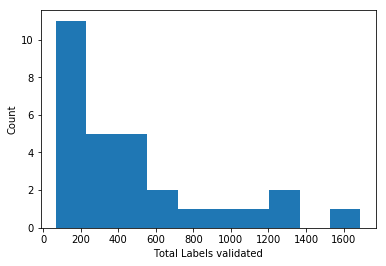

In [217]:
# Creates a histogram of labels validated
temp = []
for index, current in enumerate(users['user_id']):
    if current in old.values:
        temp.append(users['labels_validated'].iloc[index])
histogram('Total Labels validated', temp)

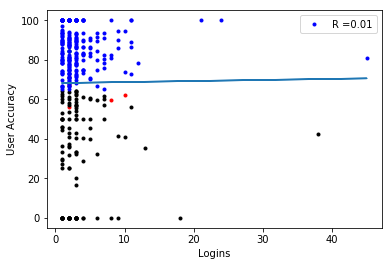

In [277]:
# Compares logins to accuracy
user_information = []
plt.ylabel('User Accuracy')
plt.xlabel('Logins')
for index, entry in enumerate(users['user_id']):
    info = users['logins'].iloc[index]
    accuracy = users['accuracy'].iloc[index]
    user_information.append([info,accuracy])
    if entry in overall_bad_users: 
#             if accuracy < 65:
        plt.plot(info, accuracy, '.', color = 'red')
    elif entry in hs_users:
        plt.plot(info, accuracy, '.', color = 'green')
    elif accuracy < 65:
        plt.plot(info, accuracy, '.', color = 'black')
    else:
        plt.plot(info, accuracy, '.', color = 'blue')
temp = np.array(user_information)
z = np.polyfit(temp[:,0],temp[:,1],1)
w = np.poly1d(z)
pears= scipy.stats.pearsonr(temp[:,1], w(temp[:,0]))
plt.plot(temp[:,0],w(temp[:,0]))
plt.legend(['R =' + str(f'{pears[0]:.2f}')])

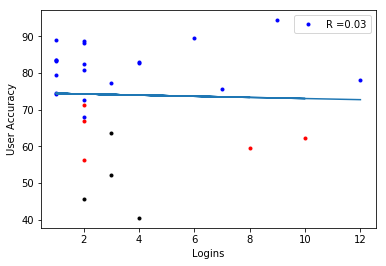

In [279]:
user_information = []
plt.ylabel('User Accuracy')
plt.xlabel('Logins')
for index, entry in enumerate(users['user_id']):
    info = users['logins'].iloc[index]
    accuracy = users['accuracy'].iloc[index]
    if entry in users_old.values:
        user_information.append([info,accuracy])
        if entry in overall_bad_users: 
    #             if accuracy < 65:
            plt.plot(info, accuracy, '.', color = 'red')
        elif entry in hs_users:
            plt.plot(info, accuracy, '.', color = 'green')
        elif accuracy < 65:
            plt.plot(info, accuracy, '.', color = 'black')
        else:
            plt.plot(info, accuracy, '.', color = 'blue')
temp = np.array(user_information)
z = np.polyfit(temp[:,0],temp[:,1],1)
w = np.poly1d(z)
pears= scipy.stats.pearsonr(temp[:,1], w(temp[:,0]))
plt.plot(temp[:,0],w(temp[:,0]))
plt.legend(['R =' + str(f'{pears[0]:.2f}')])

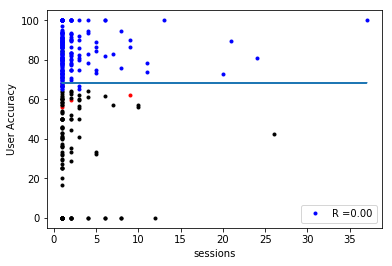

In [281]:
# Compares sessions to accuracy
user_information = []
plt.ylabel('User Accuracy')
plt.xlabel('sessions')
for index, entry in enumerate(users['user_id']):
    info = users['sessions'].iloc[index]
    accuracy = users['accuracy'].iloc[index]
    user_information.append([info,accuracy])
    if entry in overall_bad_users: 
#             if accuracy < 65:
        plt.plot(info, accuracy, '.', color = 'red')
    elif entry in hs_users:
        plt.plot(info, accuracy, '.', color = 'green')
    elif accuracy < 65:
        plt.plot(info, accuracy, '.', color = 'black')
    else:
        plt.plot(info, accuracy, '.', color = 'blue')
temp = np.array(user_information)
z = np.polyfit(temp[:,0],temp[:,1],1)
w = np.poly1d(z)
pears= scipy.stats.pearsonr(temp[:,1], w(temp[:,0]))
plt.plot(temp[:,0],w(temp[:,0]))
plt.legend(['R =' + str(f'{pears[0]:.2f}')])

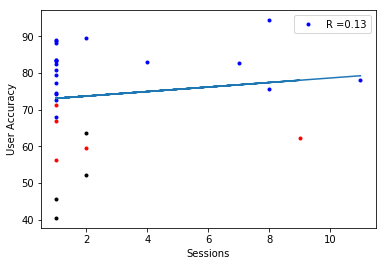

In [280]:
user_information = []
plt.ylabel('User Accuracy')
plt.xlabel('Sessions')
for index, entry in enumerate(users['user_id']):
    info = users['sessions'].iloc[index]
    accuracy = users['accuracy'].iloc[index]
    if entry in users_old.values:
        user_information.append([info,accuracy])
        if entry in overall_bad_users: 
    #             if accuracy < 65:
            plt.plot(info, accuracy, '.', color = 'red')
        elif entry in hs_users:
            plt.plot(info, accuracy, '.', color = 'green')
        elif accuracy < 65:
            plt.plot(info, accuracy, '.', color = 'black')
        else:
            plt.plot(info, accuracy, '.', color = 'blue')
temp = np.array(user_information)
z = np.polyfit(temp[:,0],temp[:,1],1)
w = np.poly1d(z)
pears= scipy.stats.pearsonr(temp[:,1], w(temp[:,0]))
plt.plot(temp[:,0],w(temp[:,0]))
plt.legend(['R =' + str(f'{pears[0]:.2f}')])

In [19]:
# Calculates the missions completed, labels placed, and accuracy of each user of a certain
# threshold
all_info = {}
for index, current_id in enumerate(users['user_id']):
    missions_completed = users['missions_completed'][index]
    total_labels = users['total_labels'][index]
    accuracy = users['accuracy'][index]
    if total_labels > 26:
        all_info[current_id] = float(total_labels) / float(missions_completed), missions_completed, accuracy

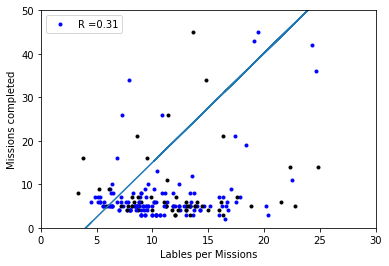

In [30]:
# Creates a graph comparing labels per mission to missions completed
user_information = all_info
plt.xlabel('Lables per Missions')
plt.ylabel('Missions completed')
plt.xlim(0, 30)
plt.ylim(0, 50)
for entry in user_information.keys():
    user_info = user_information.get(entry)
    info = user_info[0]
    missions = user_info[1]
    accuracy = user_info[2]
#     if entry in overall_bad_users:
# #         if accuracy > 65:
#         plt.plot(info, missions, '.', color = 'red')
    if accuracy < 70:
            plt.plot(info, missions, '.', color = 'black')
    else:
        plt.plot(info, missions, '.', color = 'blue')
temp = np.array(list(user_information.values()))
z = np.polyfit(temp[:,0],temp[:,1],1)
w = np.poly1d(z)
pears= scipy.stats.pearsonr(temp[:,1], w(temp[:,0]))
plt.plot(temp[:,0],w(temp[:,0]))
plt.legend(['R =' + str(f'{pears[0]:.2f}')])

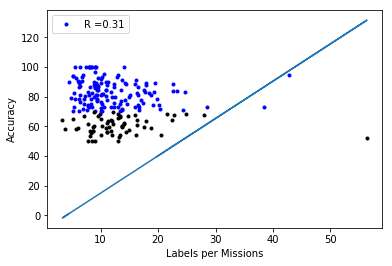

In [21]:
# Creates a graph comparing labels per mission to accuracy
plt.ylabel('Accuracy')
plt.xlabel('Labels per Missions')
for entry in user_information.keys():
    user_info = user_information.get(entry)
    info = user_info[0]
    missions = user_info[1]
    accuracy = user_info[2]
#     if entry in overall_bad_users:
# #         if accuracy > 65:
#         plt.plot(info, missions, '.', color = 'red')
    if accuracy < 70:
            plt.plot(info, accuracy, '.', color = 'black')
    else:
        plt.plot(info, accuracy, '.', color = 'blue')
temp = np.array(list(user_information.values()))
z = np.polyfit(temp[:,0],temp[:,1],1)
w = np.poly1d(z)
pears= scipy.stats.pearsonr(temp[:,1], w(temp[:,0]))
plt.plot(temp[:,0],w(temp[:,0]))
plt.legend(['R =' + str(f'{pears[0]:.2f}')])

# Features for ML Model Creation

In [184]:
# Creates a lists of each user's outputs (Quality 0 = Bad, 1 = Good, and accuracy)
# Also creates an list for features
# for the DC data, I don't have an 'accuracy' because that is based off of Seattel validations
# so their precision, recall, and worker type is recorded
def create_groups():
    for index, entry in enumerate(users['user_id']):
        current_accuracy = users['accuracy'][index]
#         current_recall = users['recall'][index]
#         current_precision = users['precision'][index]
#         current_f.measure = users['f.measure'][index]
#         worker_type = users['worker.type'][index]
        if current_accuracy <= 65:
            quality = '0'
        else:
            quality = '1'
        all_output.append([quality, current_accuracy])
        all_data[entry] = [0]
        all_id.append(entry)

In [194]:
# Adds a feature into the features list of all of the data points
# Feature is the name of the user action that is recorded
# info_type is the metric of how the feature is calculated
# feature_title is the name of the feature
# multi is if the feature should be normalized to be measured by missions & panos
def add_feature(feature, info_type, feature_title, multi):
    if feature_title not in all_feature_header:
        for index, entry in enumerate(users['user_id']):
            df_user = pd.read_csv('{0}_new.csv'.format(entry))
            if info_type == 'count':
                if multi == True:
                    by_pano = df_user.groupby(('mission_id', 'gsv_panorama_id')).apply(lambda x: sum(x['action'] == feature))
                    pano_mean = by_pano.mean()
                    pano_std = by_pano.std()
                    by_mission = df_user.groupby('mission_id').apply(lambda x: sum(x['action'] == feature))
                    mission_mean = by_mission.mean()
                    mission_std = by_mission.std()
                else:
                    info = action_count[feature] 
            elif info_type == 'pitch':
                info = df_user['pitch'].mean()     
            elif info_type == 'heading':
                df_grouped = df_user.groupby(['gsv_panorama_id'])
                current_heading = []
                for current, group in df_grouped:
                    current_heading.append(group['heading'].max() - group['heading'].min())
                info = (sum(current_heading) / float(len(current_heading))) 
            elif info_type == 'heading 350':
                df_grouped = df_user.groupby(['gsv_panorama_id'])
                full_heading_count = 0
                for current, group in df_grouped:
                    range = group['heading'].max() - group['heading'].min()
                    if range >= 350:
                        full_heading_count += 1
                info = full_heading_count / float(user_panos[entry])
            else:
                pano_mean = 0
                pano_std = 0
                mission_mean = 0
                mission_std = 0
                info = 0
            if multi:
                all_data[entry].append(mission_mean)
                all_data[entry].append(pano_mean)
                all_data[entry].append(mission_std)
                all_data[entry].append(pano_std)
            else:
                all_data[entry].append(info)
        if multi:
            all_feature_header.append(feature_title + ' per Mission')
            all_feature_header.append(feature_title + ' per Pano')
            all_feature_header.append(feature_title + ' Standard Deviation per Mission')
            all_feature_header.append(feature_title + ' Standard Deviation per Pano')
        else:
            all_feature_header.append(feature_title)

In [304]:
# Adds all of the users interaction data into a list of lists
def feature_data(feature, info_type, feature_title, multi):
    if feature_title not in all_feature_header:
        for index, entry in enumerate(users['user_id']):
            df_user = pd.read_csv('{0}_new.csv'.format(entry))
            if info_type == 'count':
                info = df_user.groupby(('mission_id', 'gsv_panorama_id')).apply(lambda x: sum(x['action'] == feature))
                info = info.tolist()
            elif info_type == 'pitch':
                info = df_user['pitch']     
            elif info_type == 'heading':
                df_grouped = df_user.groupby(['gsv_panorama_id'])
                current_heading = []
                for current, group in df_grouped:
                    current_heading.append(group['heading'].max() - group['heading'].min())
                info = current_heading
            elif info_type == 'heading 350':
                df_grouped = df_user.groupby(['gsv_panorama_id'])
                info = []
                for current, group in df_grouped:
                    range = group['heading'].max() - group['heading'].min()
                    if range >= 350:
                        info.append(1)
                    else :
                        info.append(0)
            else:
                info = 0
            all_data[entry].append(info)
        all_feature_header.append(feature_title)

In [336]:
# Creates all of the current avaliable features for a given user
def all_features(user_id):
    df_user = pd.read_csv('{0}_new.csv'.format(user_id))
    info = df_user.groupby(('mission_id', 'gsv_panorama_id'))
    counting_features_action = ['LowLevelEvent_mousedown', 'ContextMenu_TagAdded',
                                'LabelingCanvas_FinishLabeling', 'RemoveLabel',
                                'LowLevelEvent_keydown', 'Click_ZoomIn',
                                'ContextMenu_TextBoxChange', 'LowLevelEvent_mousemove']
    counting_features = ['Mouse Clicks', 'Tags Added', 'Labels Confirmed', 'Labels Removed',
                         'Key Presses', 'Zoom', 'Comments Written', 'Tags Added']
    for index, feature in enumerate(counting_features_action):
        by_pano = df_user.groupby(('mission_id', 'gsv_panorama_id')).apply(lambda x: sum(x['action'] == feature))
        pano_mean = by_pano.mean()
        pano_std = by_pano.std()
        by_mission = df_user.groupby('mission_id').apply(lambda x: sum(x['action'] == feature))
        mission_mean = by_mission.mean()
        mission_std = by_mission.std()
        users_features.append(pano_mean)
        users_features.append(pano_std)
        users_features.append(mission_mean)
        users_features.append(mission_std)
        users_features_header.append(counting_features[index] + 'Mean per Pano')
        users_features_header.append(counting_features[index] + 'Standard Deviation per Pano')
        users_features_header.append(counting_features[index] + 'Mean per Mission')
        users_features_header.append(counting_features[index] + 'Standard Deviation per Mission')
    users_features.append(df_user['pitch'].mean())
    users_features_header.append('Pitch')
    df_grouped = df_user.groupby(['gsv_panorama_id'])
    current_heading = []
    for current, group in df_grouped:
        current_heading.append(group['heading'].max() - group['heading'].min())
        full_heading_count = 0
        range = group['heading'].max() - group['heading'].min()
        if range >= 350:
            full_heading_count += 1
    users_features.append(sum(current_heading) / float(len(current_heading))) 
    users_features_header.append('Average Heading Range')
    users_features.append(full_heading_count / float(user_panos[entry]))
    users_features_header.append('Panos w/ over 350 Degrees seen')
    return users_features, users_features_header

In [338]:
# Gets all of the features for one user
current_id = '008d2723-1b96-4a51-9ffb-c4826564b352'
users_features, users_features_header = all_features(current_id)
display(users_features_header)
display(users_features)

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: FutureWarning: Interpreting tuple 'by' as a list of keys, rather than a single key. Use 'by=[...]' instead of 'by=(...)'. In the future, a tuple will always mean a single key.
  """
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: FutureWarning: Interpreting tuple 'by' as a list of keys, rather than a single key. Use 'by=[...]' instead of 'by=(...)'. In the future, a tuple will always mean a single key.
  del sys.path[0]


['Mouse ClicksMean per Pano',
 'Mouse ClicksStandard Deviation per Pano',
 'Mouse ClicksMean per Mission',
 'Mouse ClicksStandard Deviation per Mission',
 'Tags AddedMean per Pano',
 'Tags AddedStandard Deviation per Pano',
 'Tags AddedMean per Mission',
 'Tags AddedStandard Deviation per Mission',
 'Labels ConfirmedMean per Pano',
 'Labels ConfirmedStandard Deviation per Pano',
 'Labels ConfirmedMean per Mission',
 'Labels ConfirmedStandard Deviation per Mission',
 'Labels RemovedMean per Pano',
 'Labels RemovedStandard Deviation per Pano',
 'Labels RemovedMean per Mission',
 'Labels RemovedStandard Deviation per Mission',
 'Key PressesMean per Pano',
 'Key PressesStandard Deviation per Pano',
 'Key PressesMean per Mission',
 'Key PressesStandard Deviation per Mission',
 'ZoomMean per Pano',
 'ZoomStandard Deviation per Pano',
 'ZoomMean per Mission',
 'ZoomStandard Deviation per Mission',
 'Comments WrittenMean per Pano',
 'Comments WrittenStandard Deviation per Pano',
 'Comments Wri

[2.8518518518518516,
 5.397319161496207,
 25.666666666666668,
 22.744962812309307,
 0.18518518518518517,
 0.7862783338192769,
 1.6666666666666667,
 2.0816659994661326,
 0.18518518518518517,
 0.7862783338192769,
 1.6666666666666667,
 2.0816659994661326,
 0.0,
 0.0,
 0.0,
 0.0,
 0.037037037037037035,
 0.19245008972987526,
 0.3333333333333333,
 0.5773502691896258,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 438.6296296296296,
 1091.3564301133968,
 3977.3333333333335,
 2685.125198819104,
 -13.24071133555463,
 13.985,
 0.0]

[]

[]

In [298]:
# Creates empty lists to hold all of the user data
all_data = {}
all_id = []
all_output = []
all_feature_header = ['test']
output_header = ['Quality', 'accuracy']
create_groups()

In [339]:
display(all_data)
display(all_output)
display(all_feature_header)

In [1557]:
# Adds the quality of each user as a feature
# Only applicable if we know which users are poor quality due to their ability versus
# Being in neighborhoods without sidewalks
for index, entry in enumerate(users['user_id']):
    current_accuracy = users['accuracy'][index]
    if entry in overall_bad_users:
        info = 'Overall Bad User'
    elif current_accuracy <= 65:
        info = 'Bad User in Neighborhoods Without Sidewalks'
    else:
        info = 'Good User'
    current_index = all_id.index(entry)
    all_data[current_index][len(all_feaature_header)] = info

In [222]:
# adds these features into the lists (mean & standard deviation,for per pano and per mission)
add_feature( None, 'heading', 'Average Heading Range', False)
add_feature( None, 'heading 350', 'Panos w/ over 350 Degrees seen', False)
add_feature( None, 'pitch', 'Average Pitch', False)
add_feature( 'ContextMenu_TagAdded', 'count', 'Tags Added', True)
add_feature( 'LabelingCanvas_FinishLabeling', 'count', 'Labels Confirmed', True)
add_feature( 'RemoveLabel', 'count', 'Labels Removed', True)
add_feature( 'LowLevelEvent_keydown', 'count', 'Key Presses', True)
add_feature( 'LowLevelEvent_mousedown', 'count', 'Mouse Clicks', True)
add_feature( 'Click_ZoomIn', 'count', 'Zoom', True)
add_feature( 'ContextMenu_TextBoxChange', 'count', 'Comments Written', True)
add_feature( 'LowLevelEvent_mousemove', 'count', 'Mouse Movements', True)

In [309]:
# Adds these interaction data in to a lists (Creates a lists of lists)
feature_data( None, 'heading', 'Average Heading Range', False)
feature_data( None, 'heading 350', 'Panos w/ over 350 Degrees seen', False)
feature_data( None, 'pitch', 'Average Pitch', False)
feature_data( 'ContextMenu_TagAdded', 'count', 'Tags Added', True)
feature_data( 'LabelingCanvas_FinishLabeling', 'count', 'Labels Confirmed', True)
feature_data( 'RemoveLabel', 'count', 'Labels Removed', True)
feature_data( 'LowLevelEvent_keydown', 'count', 'Key Presses', True)
feature_data( 'LowLevelEvent_mousedown', 'count', 'Mouse Clicks', True)
feature_data( 'Click_ZoomIn', 'count', 'Zoom', True)
feature_data( 'ContextMenu_TextBoxChange', 'count', 'Comments Written', True)
feature_data( 'LowLevelEvent_mousemove', 'count', 'Tags Added', True)

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: FutureWarning: Interpreting tuple 'by' as a list of keys, rather than a single key. Use 'by=[...]' instead of 'by=(...)'. In the future, a tuple will always mean a single key.
  


# Dataframe for ML Model Creation

In [311]:
# Creates dataframes of the list of users features and outputs as the data with the 
# Column headers being the list of feature names / output names
df_all = pd.DataFrame(list(all_data.values()), columns = all_feature_header, index = all_id)
df_all_output = pd.DataFrame(all_output, columns = output_header, index = all_id)

In [312]:
# Drops any unwanted column
df_all = df_all.drop(columns=['test'])

In [313]:
# Creates csvs out of the dataframes
df_all.to_csv('all_users_lists_new.csv', encoding='utf-8', index=True)
df_all_output.to_csv('all_users_outputs_new.csv', encoding='utf-8', index=True)

In [229]:
# Makes a dataframe of features from a csv
df_all = pd.read_csv('all_users_new.csv')
df_all_output = pd.read_csv('all_users_outputs_new.csv')
df_all = df_all.set_index('Unnamed: 0')
df_all_output = df_all_output.set_index('Unnamed: 0')
all_feature_header = list(df_all.columns.values)

In [238]:
# turns the dataframe back into lists to be able to add more features
all_data = df_all.set_index('user_id').T.to_dict(orient = "list")

In [41]:
# Creates dataframes for training and test
number_of_training = 100
df_training = df_all.iloc[:number_of_training, :]
df_test = df_all.iloc[number_of_training:, :]
df_test_output = df_all_output.iloc[number_of_training:, :]
df_training_output = df_all_output.iloc[:number_of_training, :]

In [314]:
print('all')
display(df_all)
print('all outputs')
display(df_all_output)

all


,Mouse Movements,Average Heading Range,Panos w/ over 350 Degrees seen,Average Pitch,Tags Added,Labels Confirmed,Labels Removed,Key Presses,Mouse Clicks,Zoom,Comments Written
008d2723-1b96-4a51-9ffb-c4826564b352,"[0, 0, 3852, 320, 116, 0, 9, 95, 0, 0, 18, 53,...","[66.75, 0.0, 0.0, 0.0, 0.0, 8.0625, 0.0, 0.0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0 NaN 1 NaN 2 ...,"[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 19, 2, 1, 1, 1, 2, 1, 1, 1, 2, 1, 0, 5,...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
039d3b97-2a3d-4377-9553-3243a09eb031,"[738, 1942, 15712, 769, 2837, 368, 662, 3983, ...","[358.875, 101.203125, 36.160720825195, 358.687...","[1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, ...",0 NaN 1 NaN 2 ...,"[0, 0, 6, 0, 0, 0, 0, 1, 0, 0, 4, 0, 0, 0, 0, ...","[0, 0, 7, 0, 0, 0, 0, 1, 0, 0, 4, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 6, 31, 2, 17, 2, 3, 11, 4, 1, 51, 0, 2, 4,...","[0, 0, 1, 0, 0, 0, 0, 2, 0, 0, 2, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
054db48c-4829-4070-bcc1-68fbcfa81180,"[58, 43, 409, 54, 4843, 0, 264, 0, 154, 205, 9...","[0.0, 139.19641876220732, 36.69642639160102, 8...","[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0 NaN 1 -10.000000 2 ...,"[0, 0, 0, 0, 9, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, ...","[0, 0, 0, 0, 11, 0, 0, 0, 0, 0, 2, 0, 0, 1, 0,...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 9, 1, 102, 1, 9, 0, 6, 12, 20, 1, 0, 27...","[0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
05de1cc4-02b3-4eb7-9958-2a4a2d32b828,"[12, 47, 132, 39, 68, 13, 142, 0, 0, 152, 1139...","[357.515625, 250.3125, 34.6875, 74.25, 0.0, 19...","[1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, ...",0 -10.0 1 -10.0 2 -10.0 3...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 97, 0,...","[1, 1, 0, 1, 1, 1, 0, 0, 0, 4, 34, 0, 3, 20, 0...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
07924321-e2a1-4ff2-b311-f9b0cf92f9b0,"[502, 27, 5208, 52, 132, 195, 2917, 172, 0, 35...","[27.75, 0.0, 35.8125, 0.0, 87.0, 0.0, 0.0, 0.0...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, ...",0 -13.4375 1 -13.4375 2 -13....,"[0, 0, 7, 0, 0, 0, 4, 0, 0, 0, 0, 2, 0, 0, 0, ...","[0, 0, 7, 0, 0, 0, 4, 0, 0, 0, 0, 2, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[7, 1, 40, 3, 3, 7, 52, 5, 1, 2, 1, 6, 1, 0, 0...","[0, 0, 1, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
096e5e83-a652-4733-9743-05b67f3fe3c2,"[110, 532, 101, 0, 109, 6027, 0, 752, 79, 0, 4...","[0.0, 0.0, 0.0, 0.0, 359.64286151528376, 0.0, ...","[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, ...",0 -10.000 1 -10.000 2 -10.00...,"[0, 0, 0, 0, 0, 6, 0, 1, 0, 0, 1, 1, 1, 0, 0, ...","[0, 0, 0, 0, 0, 7, 0, 2, 0, 0, 1, 1, 1, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 134, 0, 2, 0, 0, 0, 0, 0, 0, 0...","[1, 6, 1, 0, 2, 60, 1, 7, 1, 0, 4, 5, 3, 0, 1,...","[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
096f719b-5831-4a8a-9994-828a2b562365,"[74, 314, 2248, 37, 1, 0, 67, 0, 10, 2, 122, 3...","[64.6875, 0.0, 0.0, 0.0, 0.0, 0.0, 179.9375, 0...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0 NaN 1 NaN 2 NaN 3...,"[0, 0, 7, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 7, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0,

all outputs


,Quality,accuracy
008d2723-1b96-4a51-9ffb-c4826564b352,1,100.000000
039d3b97-2a3d-4377-9553-3243a09eb031,1,100.000000
054db48c-4829-4070-bcc1-68fbcfa81180,1,100.000000
05de1cc4-02b3-4eb7-9958-2a4a2d32b828,0,59.677419
07924321-e2a1-4ff2-b311-f9b0cf92f9b0,0,57.142857
096e5e83-a652-4733-9743-05b67f3fe3c2,1,100.000000
096f719b-5831-4a8a-9994-828a2b562365,0,0.000000
0b736a27-87a7-47cb-9020-cfced7203e27,0,61.904762
0ce035b0-0367-45cb-aa83-1cb334b7c07a,1,89.743590
0d02d12f-b654-40ae-ab3f-2041acf4643a,1,90.000000


In [39]:
print('test')
display(df_test)
print('training')
display(df_training)
print('test outputs')
display(df_test_output)
print('training outputs')
display(df_training_output)

test


,Average Heading Range,Panos w/ over 350 Degrees seen,Average Pitch,Tags Added per Pano,Labels Confirmed per Pano,Labels Removed per Pano,Key Presses per Pano
100,30.593182,3,-10.539006,0,0.054545,0.000000,0.000000
101,21.885059,1,-22.201526,0,1.290323,0.000000,0.032258
102,117.812729,16,-22.463410,0,0.858974,0.012821,0.410256
103,126.094333,16,-17.307435,0,0.855072,0.014493,0.652174
104,111.103966,21,-16.329042,0,0.230769,0.012821,17.153846
105,210.490017,17,-17.722163,0,2.416667,0.111111,0.111111
106,61.053695,0,-12.313414,0,0.507042,0.014085,0.000000
107,29.365519,3,-7.953619,0,0.640625,0.062500,1.109375
108,81.730933,0,-23.424571,0,0.406780,0.000000,0.000000
109,80.233108,9,-6.769752,0,1.405405,0.027027,16.108108


training


,Average Heading Range,Panos w/ over 350 Degrees seen,Average Pitch,Tags Added per Pano,Labels Confirmed per Pano,Labels Removed per Pano,Key Presses per Pano
0,70.815394,1,-22.035794,0,0.779528,0.023622,0.000000
1,100.313378,14,-17.937205,0,0.674157,0.033708,0.000000
2,36.638980,0,-15.958228,0,1.083333,0.000000,0.000000
3,104.190889,25,-11.511745,0,1.725926,0.000000,1.622222
4,98.120584,2,-19.505424,0,0.625000,0.000000,0.000000
5,180.780869,46,-13.959864,0,1.153153,0.009009,0.000000
6,221.653351,63,-18.088388,0,1.167883,0.094891,0.000000
7,50.709289,0,-27.158799,0,0.733945,0.004587,0.000000
8,64.509399,3,-16.509843,0,1.228070,0.026316,0.000000
9,167.984784,38,-14.830287,0,1.142857,0.033613,6.882353


test outputs


,Quality,precision,recall,worker type
100,1,0.000000,NaN,anon
101,0,0.900000,0.600000,turk1
102,1,0.500000,1.000000,anon
103,1,0.500000,1.000000,turk1
104,1,0.444444,0.727273,anon
105,0,0.666667,0.600000,turk1
106,1,0.714286,0.714286,anon
107,0,0.714286,0.500000,turk1
108,1,0.333333,0.833333,anon
109,0,0.933333,0.560000,turk1


training outputs


,Quality,precision,recall,worker type
0,0,0.750000,0.529412,reg
1,1,0.750000,0.750000,turk1
2,0,0.650000,0.520000,reg
3,0,0.800000,0.533333,turk1
4,1,0.818182,0.692308,reg
5,1,0.772727,0.739130,turk1
6,1,0.850000,0.772727,turk1
7,1,0.500000,0.666667,reg
8,1,0.833333,0.666667,reg
9,0,1.000000,0.521739,turk1


# ML Model Creation

In [34]:
# Removing features with low variance, threshold being the amount of difference needed
# between each datapoints
selector = VarianceThreshold(threshold=(.8 * (1 - .8)))
df_training = selector.fit_transform(df_training)
df_test = selector.transform(df_test)

In [67]:
# SVM Classifier model
clf = svm.SVC(C = 100, gamma = 'auto', kernel = 'linear')
clf.fit(df_training, df_training_output['Quality'])

SVC(C=100, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [58]:
# SVM Regression Model
reg = svm.SVR(C = 100, gamma = 'auto', kernel = 'linear')
reg.fit(df_training, df_training_output['Accuracy'])

SVR(C=100, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='auto',
    kernel='linear', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

In [53]:
# Tree Classifier
clf = tree.DecisionTreeClassifier()
clf = clf.fit(df_training, df_training_output['Quality'])

In [55]:
# Tree Regressor
reg = tree.DecisionTreeRegressor()
reg = reg.fit(df_training, df_training_output['Accuracy'])

In [1986]:
# Neural Network Classifier
clf = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(5, 2), random_state=1)
clf.fit(df_training, df_training_output['Quality'])   

MLPClassifier(activation='relu', alpha=1e-05, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(5, 2), learning_rate='constant',
              learning_rate_init=0.001, max_iter=200, momentum=0.9,
              n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
              random_state=1, shuffle=True, solver='lbfgs', tol=0.0001,
              validation_fraction=0.1, verbose=False, warm_start=False)

In [1989]:
# Neural Network Regressor
reg = MLPRegressor(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(5, 2), random_state=1, verbose = True)
reg.fit(df_trainindf_trainingg_new, df_training_output['Accuracy'])   

MLPRegressor(activation='relu', alpha=1e-05, batch_size='auto', beta_1=0.9,
             beta_2=0.999, early_stopping=False, epsilon=1e-08,
             hidden_layer_sizes=(5, 2), learning_rate='constant',
             learning_rate_init=0.001, max_iter=200, momentum=0.9,
             n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
             random_state=1, shuffle=True, solver='lbfgs', tol=0.0001,
             validation_fraction=0.1, verbose=True, warm_start=False)

In [1382]:
# SVM SelectFromModel feature selection
selector = SelectFromModel(clf, prefit = True)
df_training = selector.transform(df_training)

In [61]:
# Tree Classifier SelectFromModel2
clf = ExtraTreesClassifier(n_estimators=50)
clf = clf.fit(df_training, df_training_output['Quality'])
clf.feature_importances_  
selector = SelectFromModel(clf, prefit=True)
df_training = selector.transform(df_training)

In [1993]:
# Tree Regressor SelectFromModel
reg = ExtraTreesRegressor(n_estimators=50)
reg = reg.fit(df_training, df_training_output['Accuracy'])
reg.feature_importances_  
selector = SelectFromModel(reg, prefit=True)
df_training = selector.transform(df_training)

In [1999]:
# Lasso regression
reg = linear_model.Lasso(alpha=0.1)
reg.fit(df_training, df_training_output['Accuracy'])

Lasso(alpha=0.1, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)

In [151]:
#  Logistic Regression
reg = LogisticRegression(random_state=0, solver='lbfgs', multi_class='multinomial')
reg.fit(df_training, df_training_output['Accuracy'])

In [2001]:
# Cross validation
scores = cross_val_score(reg, df_training, df_training_output['Accuracy'], cv=5)
display(scores)
display(scores.mean())

array([-0.02858326, -1.00742941, -1.12379948, -2.2183275 ,  0.05078919])

-0.8654700910107291

In [60]:
# Test for the svm/tree Regression models
# Displays the prediction and the model accuracy
prediction = reg.predict(df_test)
display(prediction)
display(reg.score(df_test,df_test_output['precision']))

array([0.36461517, 0.71646681, 0.7816228 , 0.74992358, 0.48536067,
       1.26536101, 0.56882026, 0.43941389, 0.71514191, 0.62333019,
       1.81825923, 0.46327021, 0.59363623, 0.91867673, 0.54249212,
       0.53274397, 0.80462601, 0.82174356, 0.46359168, 0.6475983 ,
       0.60036077, 0.61885301, 0.34042223, 1.13739005, 0.97474129,
       0.6466494 , 0.37297404, 0.65875509, 0.76963584, 0.39596978,
       0.69360053, 0.83297078])

-1.034187918657668

In [62]:
# Test for the svm/tree Classifier models
# Displays the prediction, a confusion matrix, and the model accuracy
prediction = clf.predict(df_test)
display(prediction)
display(sklearn.metrics.confusion_matrix(df_test_output['Quality'], prediction))
display(sklearn.metrics.accuracy_score(df_test_output['Quality'], prediction))

array([0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1,
       0, 0, 1, 1, 0, 1, 1, 1, 1, 0])

array([[ 5,  6],
       [ 3, 18]])

0.71875

In [70]:
# Splits the data using KFold and tests the accuracy of the Classifier multiple times
kf = KFold(n_splits=8, shuffle = True, random_state = 0)
kf.get_n_splits(df_all)
for train_index, test_index in kf.split(df_all):
    print("TRAIN:", train_index, "TEST:", test_index)
    x_train, x_test = df_all.iloc[train_index], df_all.iloc[test_index]
    y_train, y_test = df_all_output.iloc[train_index], df_all_output.iloc[test_index]
    clf.fit(x_train, y_train['Quality'])
    prediction = clf.predict(x_test)
    display(prediction)
    display(sklearn.metrics.confusion_matrix(y_test['Quality'], prediction))
    display(sklearn.metrics.accuracy_score(y_test['Quality'], prediction))

TRAIN: [  0   1   2   3   4   5   6   7   9  10  11  12  13  14  15  16  17  18
  19  20  21  23  24  25  27  28  29  31  32  33  34  35  36  37  38  39
  40  41  42  45  46  47  48  49  50  51  52  53  54  55  57  58  59  60
  61  62  63  64  65  67  68  69  70  71  72  73  74  75  76  77  79  80
  81  82  83  84  85  86  87  88  89  90  92  94  97  98 102 103 104 105
 106 107 108 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124
 125 126 127 128 129 130 131] TEST: [  8  22  26  30  43  44  56  66  78  91  93  95  96  99 100 101 109]


array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

array([[0, 8],
       [0, 9]])

0.5294117647058824

TRAIN: [  0   1   3   4   5   6   8   9  11  12  13  14  15  17  18  19  20  21
  22  23  25  26  27  28  29  30  31  32  34  35  36  37  38  39  40  41
  42  43  44  46  47  48  49  50  51  52  53  54  55  56  57  58  59  62
  64  65  66  67  69  70  72  74  75  76  77  78  79  80  81  82  83  84
  85  87  88  89  90  91  92  93  94  95  96  98  99 100 101 102 103 104
 105 106 107 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123
 124 125 126 127 128 130 131] TEST: [  2   7  10  16  24  33  45  60  61  63  68  71  73  86  97 108 129]


array([1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1])

array([[ 0,  5],
       [ 1, 11]])

0.6470588235294118

TRAIN: [  0   1   2   4   5   7   8   9  10  11  12  14  16  17  18  19  20  21
  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36  37  38  39
  41  42  43  44  45  46  47  49  53  55  56  57  58  60  61  62  63  64
  65  66  67  68  69  70  71  72  73  74  75  76  77  78  79  80  81  82
  83  85  86  87  88  89  90  91  92  93  94  95  96  97  98  99 100 101
 102 103 105 106 107 108 109 111 112 113 114 115 116 117 118 119 120 122
 123 124 127 128 129 130 131] TEST: [  3   6  13  15  40  48  50  51  52  54  59  84 104 110 121 125 126]


array([0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1])

array([[3, 3],
       [2, 9]])

0.7058823529411765

TRAIN: [  0   2   3   4   5   6   7   8   9  10  12  13  14  15  16  17  19  20
  21  22  23  24  25  26  28  29  30  31  32  33  34  35  36  37  38  39
  40  42  43  44  45  46  47  48  49  50  51  52  53  54  55  56  57  58
  59  60  61  63  64  65  66  67  68  69  70  71  72  73  74  75  77  78
  79  80  81  82  83  84  86  87  88  90  91  93  94  95  96  97  99 100
 101 102 103 104 105 107 108 109 110 111 114 116 117 119 120 121 122 123
 124 125 126 127 129 130 131] TEST: [  1  11  18  27  41  62  76  85  89  92  98 106 112 113 115 118 128]


array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

array([[ 0,  3],
       [ 0, 14]])

0.8235294117647058

TRAIN: [  1   2   3   6   7   8   9  10  11  12  13  14  15  16  18  19  20  21
  22  24  25  26  27  29  30  31  32  33  36  37  39  40  41  43  44  45
  46  47  48  49  50  51  52  54  56  57  58  59  60  61  62  63  64  65
  66  67  68  69  70  71  72  73  74  76  77  78  79  80  81  82  83  84
  85  86  87  88  89  90  91  92  93  94  95  96  97  98  99 100 101 102
 103 104 105 106 108 109 110 111 112 113 114 115 116 117 118 119 120 121
 122 124 125 126 127 128 129 131] TEST: [  0   4   5  17  23  28  34  35  38  42  53  55  75 107 123 130]


array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

array([[0, 8],
       [0, 8]])

0.5

TRAIN: [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  15  16  17  18
  20  21  22  23  24  25  26  27  28  30  33  34  35  36  37  38  39  40
  41  42  43  44  45  46  47  48  50  51  52  53  54  55  56  58  59  60
  61  62  63  65  66  67  68  69  70  71  72  73  75  76  77  78  79  80
  81  83  84  85  86  87  88  89  91  92  93  95  96  97  98  99 100 101
 102 103 104 106 107 108 109 110 112 113 114 115 117 118 119 120 121 122
 123 125 126 127 128 129 130 131] TEST: [ 14  19  29  31  32  49  57  64  74  82  90  94 105 111 116 124]


array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1])

array([[ 1,  2],
       [ 0, 13]])

0.875

TRAIN: [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  21  22  23  24  26  27  28  29  30  31  32  33  34  35  36  38
  40  41  42  43  44  45  47  48  49  50  51  52  53  54  55  56  57  58
  59  60  61  62  63  64  65  66  67  68  70  71  73  74  75  76  78  82
  83  84  85  86  87  88  89  90  91  92  93  94  95  96  97  98  99 100
 101 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 120
 121 123 124 125 126 128 129 130] TEST: [ 20  25  37  39  46  69  72  77  79  80  81 102 119 122 127 131]


array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

array([[0, 8],
       [0, 8]])

0.5

TRAIN: [  0   1   2   3   4   5   6   7   8  10  11  13  14  15  16  17  18  19
  20  22  23  24  25  26  27  28  29  30  31  32  33  34  35  37  38  39
  40  41  42  43  44  45  46  48  49  50  51  52  53  54  55  56  57  59
  60  61  62  63  64  66  68  69  71  72  73  74  75  76  77  78  79  80
  81  82  84  85  86  89  90  91  92  93  94  95  96  97  98  99 100 101
 102 104 105 106 107 108 109 110 111 112 113 115 116 118 119 121 122 123
 124 125 126 127 128 129 130 131] TEST: [  9  12  21  36  47  58  65  67  70  83  87  88 103 114 117 120]


array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

array([[ 0,  4],
       [ 0, 12]])

0.75

In [ ]:
# Splits the data using KFold and tests the accuracy of the Regressor multiple times
kf = KFold(n_splits=7, shuffle = True, random_state = 0)
kf.get_n_splits(df_all)
for train_index, test_index in kf.split(df_all):
    print("TRAIN:", train_index, "TEST:", test_index)
    x_train, x_test = df_all.iloc[train_index], df_all.iloc[test_index]
    y_train, y_test = df_all_output.iloc[train_index], df_all_output.iloc[test_index]
    reg.fit(x_train, y_train['Accuracy'])
    prediction = reg.predict(x_test)
    display(prediction)
    display(clf.score(x_test,y_test['Accuracy']))
    display(y_test['Accuracy'])

In [223]:
# Shows the tree model
tree.plot_tree(clf)

# Creates Label Accuracy Files

In [147]:
# Creates dataframes of all the label locations, and one of all of their accuracies
# Sorts both dataframes in the same order so that accuracies line up with location
df_finished_labeling = pd.read_csv('LabelingCanvas_FinishLabeling.csv')
df_all_labels = pd.read_csv('ml-label-correctness.csv')
df_finished_labeling.set_index(['audit_task_id', 'temporary_label_id'], inplace=True)
df_all_labels.set_index(['audit_task_id', 'temporary_label_id'], inplace=True)
df_all_labels.drop(columns=('user_id'), inplace=True)

In [148]:
# creates a new dataframe containing all of the information
# having lat above 46 ensures that all of the label points are from Seattle, not DC
df_joined = df_finished_labeling.join(df_all_labels)
df_joined = df_joined[~pd.isna(df_joined['correct'])]
df_joined = df_joined[df_joined['lat'] > 46]
df_joined.to_csv('all_labels.csv', encoding='utf-8', index=False)

In [1020]:
# Creates a csv of all of the labels of each users
for current_user in users['user_id']:
    current_correctness = df_joined[df_joined['user_id'] == current_user]
    current_correctness.to_csv('{0}_correctness.csv'.format(current_user), encoding='utf-8', index=False)

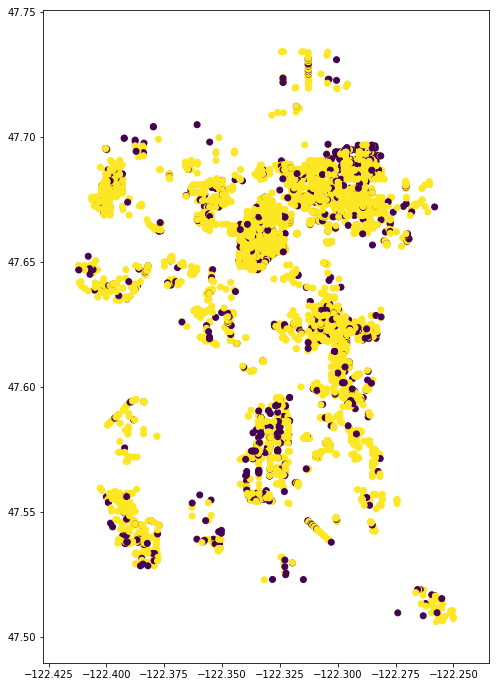

In [395]:
# Plots all validated labels
plt.figure(figsize=(8, 12))
plt.scatter(df_joined['lng'], df_joined['lat'], c = (df_joined['correct'] == 't'))

# CV

In [101]:
# Creates a dataframe of all of the seattle label's with their sv coordinates
df_sv_x_sv_y = pd.read_csv('sidewalk-seattle-label_point.csv')

In [190]:
# Creates a dataframe of all of the cv information fo each label
cv_data = []
cv_label_id = []
cv_heading = ['Timestamp', 'pano_id', 'sv_x', 'sv_y', 'label_type', 'label_id', 'user_id']
for index, current in enumerate(df_joined['label_id']):
    users_index = (df_sv_x_sv_y['label_id'] == current).idxmax()
    current_label = [df_joined['timestamp'].iloc[index], df_joined['gsv_panorama_id'].iloc[index], 
                     df_sv_x_sv_y['sv_image_x'].iloc[users_index], df_sv_x_sv_y['sv_image_y'].iloc[users_index],
                     df_joined['label_type'].iloc[index], current, df_joined['user_id'].iloc[index]]
    cv_label_id.append(current)
    cv_data.append(current_label)

In [193]:
# Creates a csv file of the label data to be inputted into the cv model
df_cv = pd.DataFrame(cv_data, columns = cv_heading, index = cv_label_id)
df_cv.to_csv('Quality_Inferance_for_cv.csv', encoding='utf-8', index=False)

In [241]:
df_summary = pd.read_csv('summary_user.csv')

In [268]:
# Checks the number of trues and false validations & the average confidence for both
df_temp = df_summary.groupby(['Correctness'])
for name,group in df_temp:
    print(name)
    print (group.agg(np.size))
    print(group.mean())

f
timestamp      10
pano_id        10
sv_x           10
sv_y           10
CVLabel        10
UserLabel      10
Confidence     10
Label_id       10
User_id        10
Correctness    10
dtype: int64
sv_x          7502.7
sv_y          -551.7
Confidence      56.4
Label_id      1427.2
dtype: float64
t
timestamp      649
pano_id        649
sv_x           649
sv_y           649
CVLabel        649
UserLabel      649
Confidence     649
Label_id       649
User_id        649
Correctness    649
dtype: int64
sv_x          6475.411402
sv_y          -587.191063
Confidence      54.473035
Label_id       584.926040
dtype: float64


In [266]:
# Adds the correctness of each user label of the cv analysis
for current_id in df_summary['Label_id']:
    label_index = (df_all_labels['label_id'] == current_id).idxmax()
    correctness = df_all_labels['correct'].iloc[label_index[0]]
    if current_id in df_summary['Label_id']:
        results_index = (df_summary['Label_id'] == current_id).idxmax() 
        df_summary['Correctness'].iloc[results_index] = correctness

In [276]:
# Checks how many labels that the cv and user has agreed on and whether they are correct or now
true = 0
false = 0
for current_id in df_summary['Label_id']:
    label_index = (df_summary['Label_id'] == current_id).idxmax()
    if df_summary['CVLabel'].iloc[label_index] == df_summary['UserLabel'].iloc[label_index]:
        if df_summary['Correctness'].iloc[label_index] == 'f':
            false += 1
        elif df_summary['Correctness'].iloc[label_index] == 't':
            true += 1
display(true)
display(false)

233

3

In [269]:
df_summary.to_csv('summary_user.csv', encoding='utf-8', index=False)

In [214]:
# Checks how many panos have had multiple users label
df_cv_grouped = df_summary.groupby(['pano_id'])
multiple_users = 0
for name, group in df_cv_grouped:
    if group['User_id'].nunique() != 1:
        multiple_users += 1
display(multiple_users)
display(len(df_cv_grouped))

51

2467

In [209]:
# Calculates the percentage that the CV model agrees with each user
df_cv_grouped = df_summary.groupby(['User_id'])
for name, group in df_cv_grouped:
        correct = 0
        total = 0
        for index, current in enumerate(group['CVLabel']):
            total += 1
            if current == group['UserLabel'].iloc[index]:
                correct += 1
        display(name)
        display(str(correct) + '/' + str(total) + '=' + str(float(correct) / float(total)))

'0e1ae564-6d72-4670-98e4-71369cc5ab26'

'75/257=0.2918287937743191'

'1353d168-ab49-4474-ae8a-213eb2dafab5'

'31/67=0.4626865671641791'

'2d9009b3-55d5-4aa8-a17a-a7c80afc4d51'

'149/413=0.36077481840193704'

'35872a6c-d171-40d9-8e66-9242b835ea71'

'6/19=0.3157894736842105'

'49723673-044d-4b47-855b-3bdebfe37073'

'217/802=0.27057356608478805'

'54c77d0f-fc8f-4497-84d3-5e336047b17e'

'18/43=0.4186046511627907'

'6809bd6e-605f-4861-bc49-32e52c88c675'

'3/11=0.2727272727272727'

'715af4d8-0f17-47c4-99c6-7ef92d94803a'

'60/174=0.3448275862068966'

'7b1596af-14d4-4f2b-9e4e-71b1884db836'

'4/14=0.2857142857142857'

'86d26e9d-010f-4802-88ba-680ae0a8e20d'

'56/172=0.32558139534883723'

'87833d72-b357-4e2c-81cd-23f58ff04c59'

'133/335=0.3970149253731343'

'8a471c0f-fa81-4c57-9b65-bd04a92c6a5e'

'13/52=0.25'

'939b6faa-0b57-4160-bcc2-d11fd2b69d9f'

'42/163=0.25766871165644173'

'9b595ba6-529b-4d37-93d7-dd189184e15a'

'54/163=0.3312883435582822'

'ac272eb8-3bb3-4260-9960-8e6c463f3867'

'12/25=0.48'

'af812204-1521-4c42-bf88-4baaaffe3f06'

'37/112=0.33035714285714285'

'bb64c416-b0bb-4a5b-b369-00f2a56fea3a'

'16/42=0.38095238095238093'

'bca24c1a-a6b1-4625-ab8e-9ff8693022d7'

'58/168=0.34523809523809523'

'bf16418a-4c99-4fd6-99c6-7e8b40fbe17b'

'63/191=0.3298429319371728'

'c7190807-b56e-40c5-b96e-49dc8368328c'

'3/11=0.2727272727272727'

'd3636d4c-2d16-410c-bf44-c066ecaf1c31'

'2/12=0.16666666666666666'

'dada416e-535f-4bb3-a213-172a8a94b581'

'32/100=0.32'

'dce5984b-25d9-48f9-b8b7-640202b3be3c'

'0/2=0.0'

'e4ff325c-309b-4ea6-8555-8f973e662362'

'109/283=0.38515901060070673'

'ec15a589-dd14-4513-a43e-8c06e55f4c71'

'29/88=0.32954545454545453'

'f13d2630-35fd-4a78-883d-d108be083425'

'29/81=0.35802469135802467'

'f5314ef9-3877-438c-ba65-ee2a2bbbf7f5'

'15/42=0.35714285714285715'

'fa0bbee4-b98d-4eb3-b6da-d9e9aa287f6c'

'81/259=0.3127413127413127'

In [45]:
# Checks the number of labels in every pano
minimum_label_count = 7
df_joined_groups = df_joined.groupby(['gsv_panorama_id'])
for name,group in df_joined_groups:
    if len(group['gsv_panorama_id'].agg(np.size)) > minimum_label_count:
        print(name)
        display(len(group['gsv_panorama_id'].agg(np.size)))

0o5UD2lV47rsCz1NNl2_WQ


12

4Czt4q0BsHpIvLTRccKRuQ


12

55JjCbPXgFP2w7ubAXi7Vw


24

_ThcAfjL-9PVTI2IGWcIkg


9

aP5ZY6IHE3lziMBQQutnVg


10

oqP7byVfpym5eotQ9U4fdA


9

wuk--sZ3fJyMsMo4tJuybg


9

xknXWuoxVvX58NGN6sJ2vQ


9

# Accuracy by Label Type

In [34]:
# Determines a user's accuracy for each of the label types
df_all_grouped = df_all_labels.groupby(['user_id','label_type'])
label_type_accuracy = {}
for current, group in df_all_grouped:
    users_index = (users['user_id'] == current[0]).idxmax()
    correct = sum(group['correct'] == 't')
    false = sum(group['correct'] =='f')
    if correct + false != 0:
        label_type_accuracy[current] = (correct / (correct + false))

In [84]:
# Plots a given feature against the user's accuracy on the 4 label types
def label_accuracy_per_type(feature_name):
    f, axs = plt.subplots(2,2,figsize=(12,8))
    plt.subplot(221)
    label_type_accuracy_graph('CurbRamp', feature_name)
    plt.subplot(222)
    label_type_accuracy_graph('NoCurbRamp', feature_name)
    plt.subplot(223)
    label_type_accuracy_graph('Obstacle', feature_name)
    plt.subplot(224)
    label_type_accuracy_graph('SurfaceProblem', feature_name)

In [85]:
# Plots features versus accuracies of different label types
def label_type_accuracy_graph(label_type, feature_name):
    user_information = {}
    for index, current_user in enumerate(users['user_id']):
        feature_info = df_all.at[current_user, feature_name]
        user_information[current_user] = feature_info , label_type_accuracy[current_user,label_type] 
    label_scatter_plot(feature_name, user_information, label_type)

In [86]:
# Plots the feature versus the label type accuracy
def label_scatter_plot(info_type, user_information, label_type):
    for entry in user_information.keys():
        users_index = (users['user_id'] == entry).idxmax()
        user_info = user_information.get(entry)
        info = user_info[0]
        accuracy = user_info[1]
        user_accuracy = users.at[users_index,'accuracy']
        if entry in overall_bad_users:
            current_color = 'red'
        elif user_accuracy < 65:
            current_color = 'black'
        else:
            current_color = 'blue'
        plt.plot(info, accuracy, '.', color = current_color)
    temp = np.array(list(user_information.values()))
    z = np.polyfit(temp[:,0],temp[:,1],1)
    w = np.poly1d(z)
    pears= scipy.stats.pearsonr(temp[:,1], w(temp[:,0]))
    plt.plot(temp[:,0],w(temp[:,0]))
    plt.legend(['R =' + str(f'{pears[0]:.2f}')])

In [89]:
# Average Pitch compared to the accuracy of all 4 label types
label_accuracy_per_type('Average Pitch')

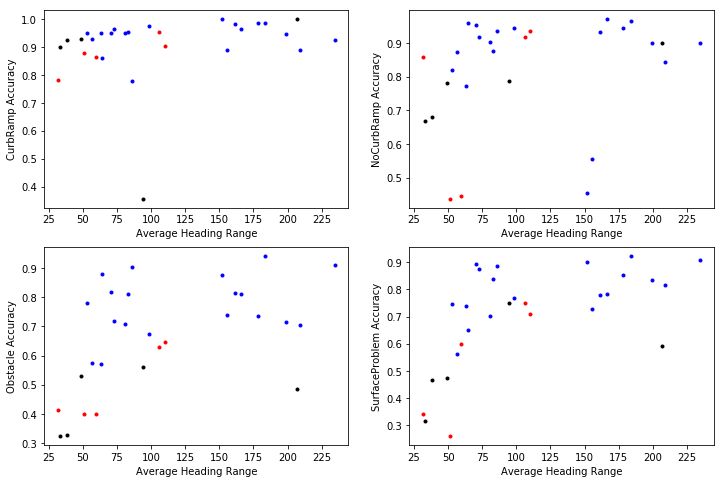

In [1521]:
# Average heading range compared to the accuracy of all 4 label types
label_accuracy_per_type('Average Heading Range')

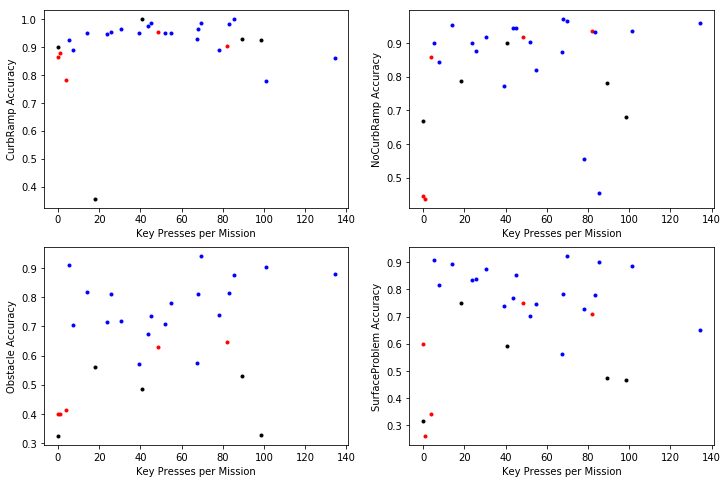

In [1522]:
# Key presses compared to the accuracy of all 4 label types
label_accuracy_per_type('Key Presses per Mission')

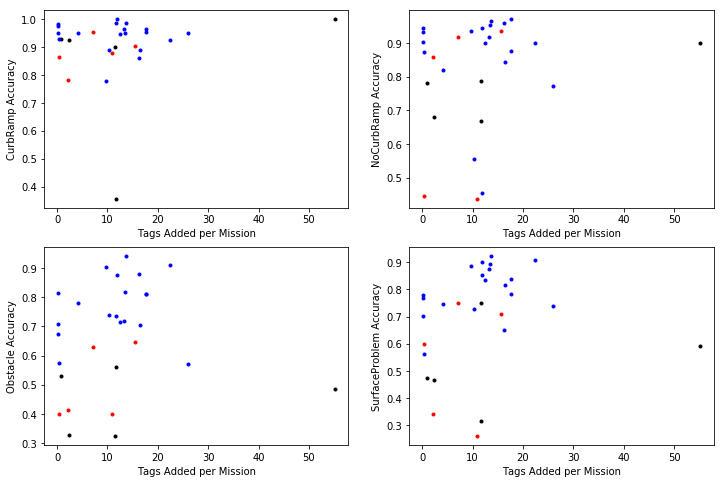

In [1523]:
# Tags added compared to the accuracy of all 4 label types
label_accuracy_per_type('Tags Added per Mission')

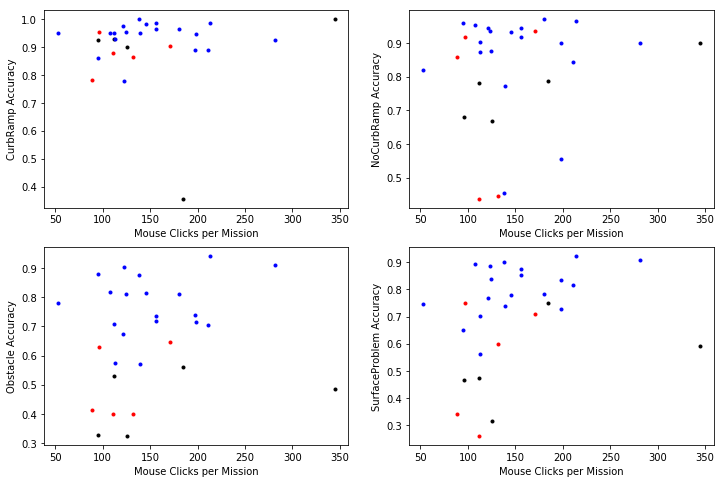

In [1524]:
# Mouse Clicks compared to the accuracy of all 4 label types
label_accuracy_per_type('Mouse Clicks per Mission')

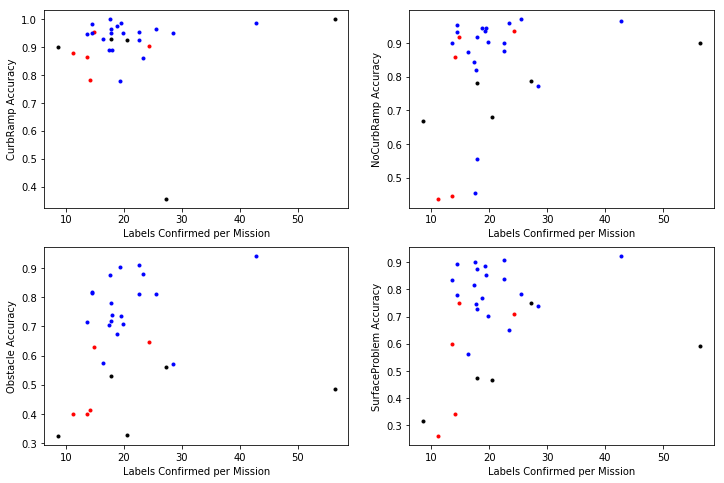

In [1525]:
# Labels confirmed compared to the accuracy of all 4 label types
label_accuracy_per_type('Labels Confirmed per Mission')

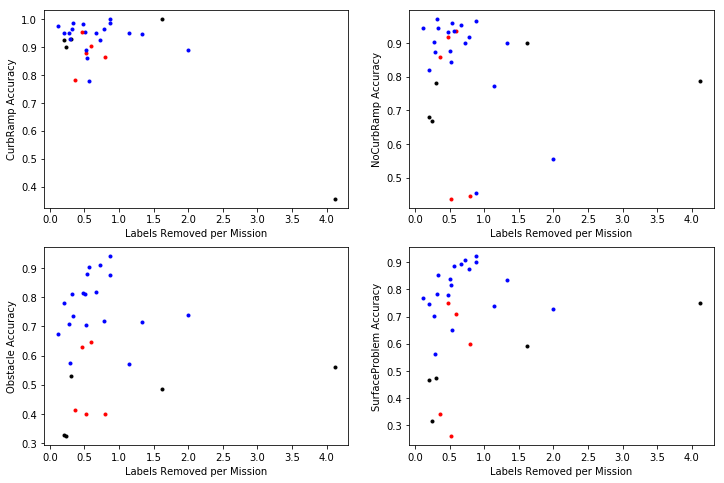

In [1526]:
# labels removed compared to the accuracy of all 4 label types
label_accuracy_per_type('Labels Removed per Mission')

# Feature Comparisons

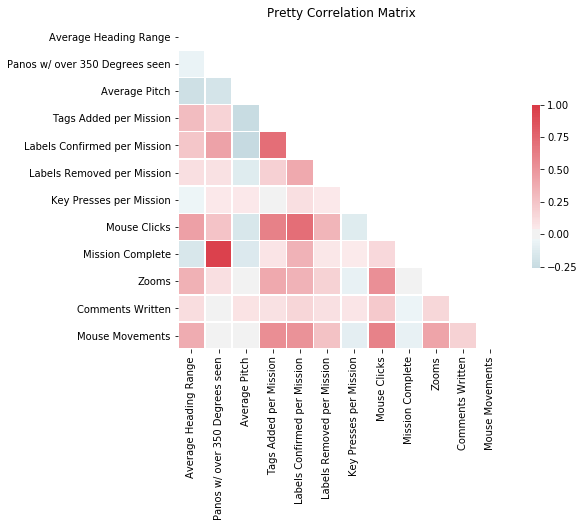

In [205]:
# Compute the correlation matrix
corr = df_all.corr()
# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from (mask)] = True
# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(10, 6))
ax.set_title('Pretty Correlation Matrix')
# Generate a custom diverging colormap
cmap = sns.diverging_palette (220, 10, as_cmap=True)
# Draw heatmap w/the mask & correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1, center=0, square=True, linewidths=.5,cbar_kws={"shrink":.5})

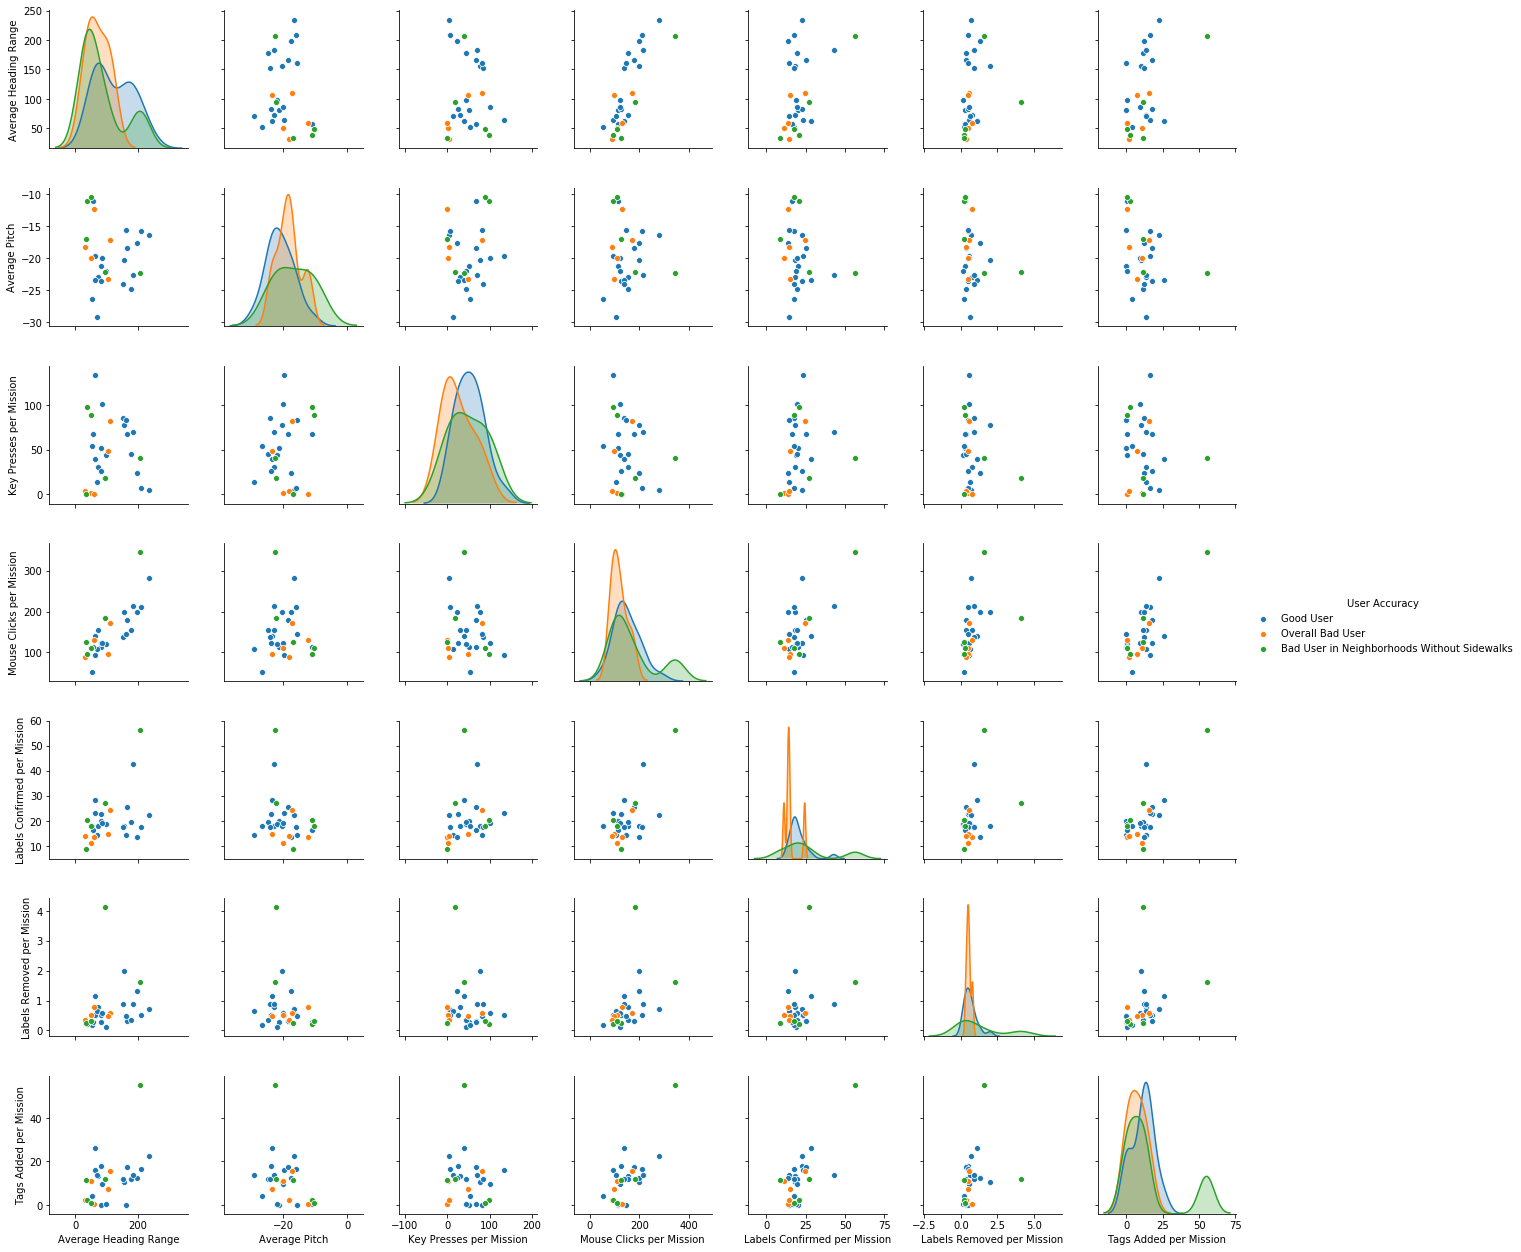

In [1573]:
# Compares how different features are related to each other
sns_plot = sns.pairplot(df_all, hue='User Accuracy')

# High School Student

In [216]:
hs_interaction = pd.read_csv('ml-interactions-jaaonraces.csv')
hs_labels = pd.read_csv('ml-label-correctness-jaaonraces.csv')

In [217]:
# Calculates the label stats of the high school student
total = len(hs_labels)
accuracy = 0
correct = sum(hs_labels['correct'] == 't')
false = sum(hs_labels['correct'] == 'f')
validated = correct + false
if validated != 0:
    accuracy = float(correct) / float(validated) * 100
missions_completed = user_missions[hs_labels['user_id'][1]]
hs_info = hs_labels['user_id'][1], total, validated, correct, false,  accuracy, missions_completed

In [239]:
# displays the features and info of the high school student
display(hs_info)
display(user_missions['d2b04e27-13ce-4aff-a06a-7c7147c96696'])
hs_features = df_all.iloc[139]
display(hs_features)

Zoom per Mission                                      1.500000
Zoom per Pano                                         0.097561
Zoom Standard Deviation per Mission                   1.511858
Zoom Standard Deviation per Pano                      0.451130
Average Heading Range                               180.571350
Panos w/ over 350 Degrees seen per Panos              0.382609
Average Pitch                                       -16.209073
Tags Added per Mission                                5.250000
Tags Added per Pano                                   0.341463
Tags Added Standard Deviation per Mission             5.548488
Tags Added Standard Deviation per Pano                0.948072
Labels Confirmed per Mission                         10.875000
Labels Confirmed per Pano                             0.707317
Labels Confirmed Standard Deviation per Mission      11.593563
Labels Confirmed Standard Deviation per Pano          1.965822
Labels Removed per Mission                            0

# DC Data

In [244]:
# Reads all of the dc data by users and indexes it
dc_anon = pd.read_csv('dc-anon-interactions.csv')
dc_registered = pd.read_csv('dc-registered-interactions.csv')
dc_turk = pd.read_csv('dc-turker-interactions.csv')
dc_anon.set_index(['audit_task_id', 'temporary_label_id'], inplace=True)
dc_registered.set_index(['audit_task_id', 'temporary_label_id'], inplace=True)
dc_turk.set_index(['audit_task_id', 'temporary_label_id'], inplace=True)

In [30]:
# combines all of the dc data into one dataframe and makes it into a csv
dc_all = pd.concat((dc_registered, dc_anon, dc_turk))
dc_all.to_csv('dc-all-interactions.csv', encoding='utf-8', index=False)

In [12]:
dc_all = pd.read_csv('dc-all-interactions.csv')

In [10]:
dc_users = pd.read_csv('cv-accuracy.csv')

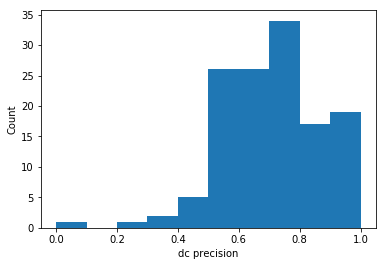

In [271]:
histogram('dc precision', dc_users['precision'])

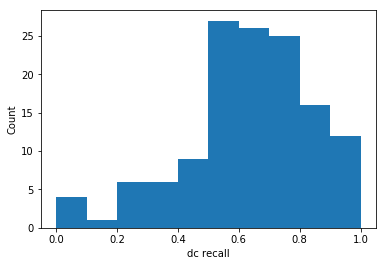

In [268]:
histogram('dc recall', dc_users['recall'])

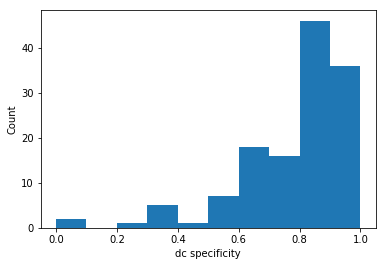

In [269]:
histogram('dc specificity', dc_users['specificity'])

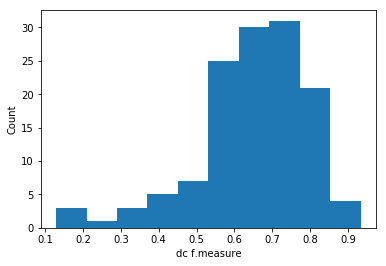

In [270]:
histogram('dc f.measure', dc_users['f.measure'])

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy
users = pd.read_csv('users_one_mission.csv')

Training label classifier...
Training accuracy classifier...


/Users/daonation/Downloads/Project Sidewalk/sidewalk-quality-analysis/classifier.py:62: FutureWarning: Interpreting tuple 'by' as a list of keys, rather than a single key. Use 'by=[...]' instead of 'by=(...)'. In the future, a tuple will always mean a single key.
  info = df_user.groupby(('mission_id', 'gsv_panorama_id'))
/Users/daonation/Downloads/Project Sidewalk/sidewalk-quality-analysis/classifier.py:73: FutureWarning: Interpreting tuple 'by' as a list of keys, rather than a single key. Use 'by=[...]' instead of 'by=(...)'. In the future, a tuple will always mean a single key.
  by_pano = df_user.groupby(('mission_id', 'gsv_panorama_id')).apply(lambda x: sum(x['action'] == feature))
/Users/daonation/Downloads/Project Sidewalk/sidewalk-quality-analysis/classifier.py:62: FutureWarning: Interpreting tuple 'by' as a list of keys, rather than a single key. Use 'by=[...]' instead of 'by=(...)'. In the future, a tuple will always mean a single key.
  info = df_user.groupby(('mission_id', 

/Users/daonation/Downloads/Project Sidewalk/sidewalk-quality-analysis/classifier.py:62: FutureWarning: Interpreting tuple 'by' as a list of keys, rather than a single key. Use 'by=[...]' instead of 'by=(...)'. In the future, a tuple will always mean a single key.
  info = df_user.groupby(('mission_id', 'gsv_panorama_id'))
/Users/daonation/Downloads/Project Sidewalk/sidewalk-quality-analysis/classifier.py:73: FutureWarning: Interpreting tuple 'by' as a list of keys, rather than a single key. Use 'by=[...]' instead of 'by=(...)'. In the future, a tuple will always mean a single key.
  by_pano = df_user.groupby(('mission_id', 'gsv_panorama_id')).apply(lambda x: sum(x['action'] == feature))
/Users/daonation/Downloads/Project Sidewalk/sidewalk-quality-analysis/classifier.py:62: FutureWarning: Interpreting tuple 'by' as a list of keys, rather than a single key. Use 'by=[...]' instead of 'by=(...)'. In the future, a tuple will always mean a single key.
  info = df_user.groupby(('mission_id', 

/Users/daonation/Downloads/Project Sidewalk/sidewalk-quality-analysis/classifier.py:62: FutureWarning: Interpreting tuple 'by' as a list of keys, rather than a single key. Use 'by=[...]' instead of 'by=(...)'. In the future, a tuple will always mean a single key.
  info = df_user.groupby(('mission_id', 'gsv_panorama_id'))
/Users/daonation/Downloads/Project Sidewalk/sidewalk-quality-analysis/classifier.py:73: FutureWarning: Interpreting tuple 'by' as a list of keys, rather than a single key. Use 'by=[...]' instead of 'by=(...)'. In the future, a tuple will always mean a single key.
  by_pano = df_user.groupby(('mission_id', 'gsv_panorama_id')).apply(lambda x: sum(x['action'] == feature))
/Users/daonation/Downloads/Project Sidewalk/sidewalk-quality-analysis/classifier.py:62: FutureWarning: Interpreting tuple 'by' as a list of keys, rather than a single key. Use 'by=[...]' instead of 'by=(...)'. In the future, a tuple will always mean a single key.
  info = df_user.groupby(('mission_id', 

/Users/daonation/Downloads/Project Sidewalk/sidewalk-quality-analysis/classifier.py:62: FutureWarning: Interpreting tuple 'by' as a list of keys, rather than a single key. Use 'by=[...]' instead of 'by=(...)'. In the future, a tuple will always mean a single key.
  info = df_user.groupby(('mission_id', 'gsv_panorama_id'))
/Users/daonation/Downloads/Project Sidewalk/sidewalk-quality-analysis/classifier.py:73: FutureWarning: Interpreting tuple 'by' as a list of keys, rather than a single key. Use 'by=[...]' instead of 'by=(...)'. In the future, a tuple will always mean a single key.
  by_pano = df_user.groupby(('mission_id', 'gsv_panorama_id')).apply(lambda x: sum(x['action'] == feature))
/Users/daonation/Downloads/Project Sidewalk/sidewalk-quality-analysis/classifier.py:62: FutureWarning: Interpreting tuple 'by' as a list of keys, rather than a single key. Use 'by=[...]' instead of 'by=(...)'. In the future, a tuple will always mean a single key.
  info = df_user.groupby(('mission_id', 

/Users/daonation/Downloads/Project Sidewalk/sidewalk-quality-analysis/classifier.py:62: FutureWarning: Interpreting tuple 'by' as a list of keys, rather than a single key. Use 'by=[...]' instead of 'by=(...)'. In the future, a tuple will always mean a single key.
  info = df_user.groupby(('mission_id', 'gsv_panorama_id'))
/Users/daonation/Downloads/Project Sidewalk/sidewalk-quality-analysis/classifier.py:73: FutureWarning: Interpreting tuple 'by' as a list of keys, rather than a single key. Use 'by=[...]' instead of 'by=(...)'. In the future, a tuple will always mean a single key.
  by_pano = df_user.groupby(('mission_id', 'gsv_panorama_id')).apply(lambda x: sum(x['action'] == feature))
/Users/daonation/Downloads/Project Sidewalk/sidewalk-quality-analysis/classifier.py:62: FutureWarning: Interpreting tuple 'by' as a list of keys, rather than a single key. Use 'by=[...]' instead of 'by=(...)'. In the future, a tuple will always mean a single key.
  info = df_user.groupby(('mission_id', 

R = 0.19


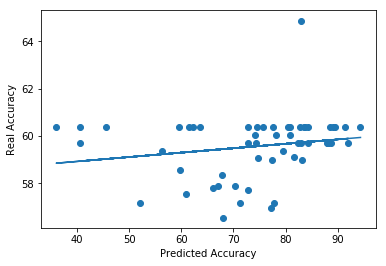

In [3]:
import classifier
clf = classifier.UserQualityRegressor()
clf.fit('ml-label-correctness-one-mission.csv', 'sidewalk-seattle-label_point.csv', 
        'users_one_mission.csv', 'all_users_new_mean.csv')
model_error = 0
total_percentage = 0
user_count = 0
all_predicted_accuracy = []
all_actual_accuracy = []
users_for_training = users[users['labels_validated'] > 25].index
half = int(len(users_for_training) / 2)
users_labels_test = users_for_training[half:]
for index, current_user in enumerate(users['user_id']):
#     if current_user == '9005a64a-fa73-4c84-b08b-b61eece1b9b7':
#     if index in users_labels_test:
    if users['labels_validated'][index] > 45:
        model_prediction = clf.predict_one_user('{0}_new.csv'.format(current_user), 
                                                 'ml-label-correctness-one-mission.csv',
                                                 'sidewalk-seattle-label_point.csv', 
                                                 'panos_seen.csv', current_user)
        actual_accuracy = users['accuracy'][index]
        all_predicted_accuracy.append(model_prediction)
        all_actual_accuracy.append(actual_accuracy)
#         if model_prediction >= actual_accuracy:
#             model_error += model_prediction - actual_accuracy
#         else:
#             model_error += ((model_prediction - actual_accuracy) * -1)
#         total_percentage += (model_prediction / actual_accuracy)
#         user_count += 1
#         print('Prediction: ' + str(model_prediction) + ' Actual: ' + str(actual_accuracy) +
#               ' Difference: ' + str(model_prediction - actual_accuracy))
# print('model accuracy: ' + str(float(total_percentage) / float(user_count)))
plt.figure()
plt.ylabel('Real Accuracy')
plt.xlabel('Predicted Accuracy')
z = np.polyfit(all_actual_accuracy, all_predicted_accuracy, 1)
w = np.poly1d(z)
pears = scipy.stats.pearsonr(all_actual_accuracy, all_predicted_accuracy)
plt.scatter( all_actual_accuracy,all_predicted_accuracy)
plt.plot(all_actual_accuracy, w(all_actual_accuracy))
print('R = ' + str(f'{pears[0]:.2f}'))

R = 0.19


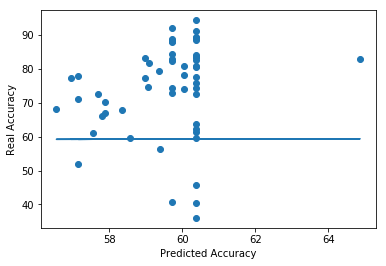

In [4]:
plt.figure()
plt.ylabel('Real Accuracy')
plt.xlabel('Predicted Accuracy')
z = np.polyfit(all_actual_accuracy, all_predicted_accuracy, 1)
w = np.poly1d(z)
pears = scipy.stats.pearsonr(all_actual_accuracy, all_predicted_accuracy)
plt.scatter( all_predicted_accuracy,all_actual_accuracy)
plt.plot(all_predicted_accuracy, w(all_predicted_accuracy))
print('R = ' + str(f'{pears[0]:.2f}'))

In [6]:
import classifier
clf = classifier.UserQualityRegressor()
clf.fit('ml-label-correctness-one-mission.csv', 'sidewalk-seattle-label_point.csv', 
        'users_one_mission.csv', 'all_users_new_mean.csv')
model_error = 0
total_percentage = 0
user_count = 0
users_for_training = users[users['labels_validated'] > 25].index
half = int(len(users_for_training) / 2)
users_labels_train = users_for_training[:half]
for index, current_user in enumerate(users['user_id']):
#     if current_user == '9005a64a-fa73-4c84-b08b-b61eece1b9b7':
    if index in users_labels_train:
#     if users['labels_validated'][index] > 45:
        model_prediction = clf.predict_one_user('{0}_new.csv'.format(current_user), 
                                                 'ml-label-correctness-one-mission.csv',
                                                 'sidewalk-seattle-label_point.csv', 
                                                 'panos_seen.csv', current_user)
        actual_accuracy = users['accuracy'][index]
        if model_prediction >= actual_accuracy:
            model_error += model_prediction - actual_accuracy
        else:
            model_error += ((model_prediction - actual_accuracy) * -1)
        total_percentage += (model_prediction / actual_accuracy)
        user_count += 1
        print('Prediction: ' + str(model_prediction) + ' Actual: ' + str(actual_accuracy) +
              ' Difference: ' + str(model_prediction - actual_accuracy))
print('model error: ' + str(model_error / user_count))
print('model accuracy: ' + str(float(total_percentage) / float(user_count)))

Training label classifier...
Training accuracy classifier...


/Users/daonation/Downloads/Project Sidewalk/sidewalk-quality-analysis/classifier.py:57: FutureWarning: Interpreting tuple 'by' as a list of keys, rather than a single key. Use 'by=[...]' instead of 'by=(...)'. In the future, a tuple will always mean a single key.
  info = df_user.groupby(('mission_id', 'gsv_panorama_id'))
/Users/daonation/Downloads/Project Sidewalk/sidewalk-quality-analysis/classifier.py:68: FutureWarning: Interpreting tuple 'by' as a list of keys, rather than a single key. Use 'by=[...]' instead of 'by=(...)'. In the future, a tuple will always mean a single key.
  by_pano = df_user.groupby(('mission_id', 'gsv_panorama_id')).apply(lambda x: sum(x['action'] == feature))


Prediction: 60.414312793573345 Actual: 59.67741935483871 Difference: 0.7368934387346329


/Users/daonation/Downloads/Project Sidewalk/sidewalk-quality-analysis/classifier.py:57: FutureWarning: Interpreting tuple 'by' as a list of keys, rather than a single key. Use 'by=[...]' instead of 'by=(...)'. In the future, a tuple will always mean a single key.
  info = df_user.groupby(('mission_id', 'gsv_panorama_id'))
/Users/daonation/Downloads/Project Sidewalk/sidewalk-quality-analysis/classifier.py:68: FutureWarning: Interpreting tuple 'by' as a list of keys, rather than a single key. Use 'by=[...]' instead of 'by=(...)'. In the future, a tuple will always mean a single key.
  by_pano = df_user.groupby(('mission_id', 'gsv_panorama_id')).apply(lambda x: sum(x['action'] == feature))


Prediction: 61.817954473530804 Actual: 89.74358974358975 Difference: -27.925635270058947


/Users/daonation/Downloads/Project Sidewalk/sidewalk-quality-analysis/classifier.py:57: FutureWarning: Interpreting tuple 'by' as a list of keys, rather than a single key. Use 'by=[...]' instead of 'by=(...)'. In the future, a tuple will always mean a single key.
  info = df_user.groupby(('mission_id', 'gsv_panorama_id'))
/Users/daonation/Downloads/Project Sidewalk/sidewalk-quality-analysis/classifier.py:68: FutureWarning: Interpreting tuple 'by' as a list of keys, rather than a single key. Use 'by=[...]' instead of 'by=(...)'. In the future, a tuple will always mean a single key.
  by_pano = df_user.groupby(('mission_id', 'gsv_panorama_id')).apply(lambda x: sum(x['action'] == feature))


Prediction: 61.28572574620325 Actual: 60.0 Difference: 1.2857257462032479


/Users/daonation/Downloads/Project Sidewalk/sidewalk-quality-analysis/classifier.py:57: FutureWarning: Interpreting tuple 'by' as a list of keys, rather than a single key. Use 'by=[...]' instead of 'by=(...)'. In the future, a tuple will always mean a single key.
  info = df_user.groupby(('mission_id', 'gsv_panorama_id'))
/Users/daonation/Downloads/Project Sidewalk/sidewalk-quality-analysis/classifier.py:68: FutureWarning: Interpreting tuple 'by' as a list of keys, rather than a single key. Use 'by=[...]' instead of 'by=(...)'. In the future, a tuple will always mean a single key.
  by_pano = df_user.groupby(('mission_id', 'gsv_panorama_id')).apply(lambda x: sum(x['action'] == feature))


Prediction: 62.589980070988446 Actual: 78.16568047337276 Difference: -15.575700402384314


/Users/daonation/Downloads/Project Sidewalk/sidewalk-quality-analysis/classifier.py:57: FutureWarning: Interpreting tuple 'by' as a list of keys, rather than a single key. Use 'by=[...]' instead of 'by=(...)'. In the future, a tuple will always mean a single key.
  info = df_user.groupby(('mission_id', 'gsv_panorama_id'))
/Users/daonation/Downloads/Project Sidewalk/sidewalk-quality-analysis/classifier.py:68: FutureWarning: Interpreting tuple 'by' as a list of keys, rather than a single key. Use 'by=[...]' instead of 'by=(...)'. In the future, a tuple will always mean a single key.
  by_pano = df_user.groupby(('mission_id', 'gsv_panorama_id')).apply(lambda x: sum(x['action'] == feature))


Prediction: 62.574518579808256 Actual: 56.338028169014095 Difference: 6.236490410794161


/Users/daonation/Downloads/Project Sidewalk/sidewalk-quality-analysis/classifier.py:57: FutureWarning: Interpreting tuple 'by' as a list of keys, rather than a single key. Use 'by=[...]' instead of 'by=(...)'. In the future, a tuple will always mean a single key.
  info = df_user.groupby(('mission_id', 'gsv_panorama_id'))
/Users/daonation/Downloads/Project Sidewalk/sidewalk-quality-analysis/classifier.py:68: FutureWarning: Interpreting tuple 'by' as a list of keys, rather than a single key. Use 'by=[...]' instead of 'by=(...)'. In the future, a tuple will always mean a single key.
  by_pano = df_user.groupby(('mission_id', 'gsv_panorama_id')).apply(lambda x: sum(x['action'] == feature))


Prediction: 57.34873612590788 Actual: 25.0 Difference: 32.34873612590788


/Users/daonation/Downloads/Project Sidewalk/sidewalk-quality-analysis/classifier.py:57: FutureWarning: Interpreting tuple 'by' as a list of keys, rather than a single key. Use 'by=[...]' instead of 'by=(...)'. In the future, a tuple will always mean a single key.
  info = df_user.groupby(('mission_id', 'gsv_panorama_id'))
/Users/daonation/Downloads/Project Sidewalk/sidewalk-quality-analysis/classifier.py:68: FutureWarning: Interpreting tuple 'by' as a list of keys, rather than a single key. Use 'by=[...]' instead of 'by=(...)'. In the future, a tuple will always mean a single key.
  by_pano = df_user.groupby(('mission_id', 'gsv_panorama_id')).apply(lambda x: sum(x['action'] == feature))


Prediction: 61.10299659795685 Actual: 68.08510638297872 Difference: -6.982109785021869


/Users/daonation/Downloads/Project Sidewalk/sidewalk-quality-analysis/classifier.py:57: FutureWarning: Interpreting tuple 'by' as a list of keys, rather than a single key. Use 'by=[...]' instead of 'by=(...)'. In the future, a tuple will always mean a single key.
  info = df_user.groupby(('mission_id', 'gsv_panorama_id'))
/Users/daonation/Downloads/Project Sidewalk/sidewalk-quality-analysis/classifier.py:68: FutureWarning: Interpreting tuple 'by' as a list of keys, rather than a single key. Use 'by=[...]' instead of 'by=(...)'. In the future, a tuple will always mean a single key.
  by_pano = df_user.groupby(('mission_id', 'gsv_panorama_id')).apply(lambda x: sum(x['action'] == feature))


Prediction: 62.0679291356423 Actual: 90.625 Difference: -28.557070864357698


/Users/daonation/Downloads/Project Sidewalk/sidewalk-quality-analysis/classifier.py:57: FutureWarning: Interpreting tuple 'by' as a list of keys, rather than a single key. Use 'by=[...]' instead of 'by=(...)'. In the future, a tuple will always mean a single key.
  info = df_user.groupby(('mission_id', 'gsv_panorama_id'))
/Users/daonation/Downloads/Project Sidewalk/sidewalk-quality-analysis/classifier.py:68: FutureWarning: Interpreting tuple 'by' as a list of keys, rather than a single key. Use 'by=[...]' instead of 'by=(...)'. In the future, a tuple will always mean a single key.
  by_pano = df_user.groupby(('mission_id', 'gsv_panorama_id')).apply(lambda x: sum(x['action'] == feature))


Prediction: 61.98008742616658 Actual: 68.29268292682927 Difference: -6.312595500662695


/Users/daonation/Downloads/Project Sidewalk/sidewalk-quality-analysis/classifier.py:57: FutureWarning: Interpreting tuple 'by' as a list of keys, rather than a single key. Use 'by=[...]' instead of 'by=(...)'. In the future, a tuple will always mean a single key.
  info = df_user.groupby(('mission_id', 'gsv_panorama_id'))
/Users/daonation/Downloads/Project Sidewalk/sidewalk-quality-analysis/classifier.py:68: FutureWarning: Interpreting tuple 'by' as a list of keys, rather than a single key. Use 'by=[...]' instead of 'by=(...)'. In the future, a tuple will always mean a single key.
  by_pano = df_user.groupby(('mission_id', 'gsv_panorama_id')).apply(lambda x: sum(x['action'] == feature))


Prediction: 59.83263322449277 Actual: 62.06896551724138 Difference: -2.236332292748614


/Users/daonation/Downloads/Project Sidewalk/sidewalk-quality-analysis/classifier.py:57: FutureWarning: Interpreting tuple 'by' as a list of keys, rather than a single key. Use 'by=[...]' instead of 'by=(...)'. In the future, a tuple will always mean a single key.
  info = df_user.groupby(('mission_id', 'gsv_panorama_id'))
/Users/daonation/Downloads/Project Sidewalk/sidewalk-quality-analysis/classifier.py:68: FutureWarning: Interpreting tuple 'by' as a list of keys, rather than a single key. Use 'by=[...]' instead of 'by=(...)'. In the future, a tuple will always mean a single key.
  by_pano = df_user.groupby(('mission_id', 'gsv_panorama_id')).apply(lambda x: sum(x['action'] == feature))


Prediction: 63.657672725385886 Actual: 84.21052631578947 Difference: -20.55285359040358


/Users/daonation/Downloads/Project Sidewalk/sidewalk-quality-analysis/classifier.py:57: FutureWarning: Interpreting tuple 'by' as a list of keys, rather than a single key. Use 'by=[...]' instead of 'by=(...)'. In the future, a tuple will always mean a single key.
  info = df_user.groupby(('mission_id', 'gsv_panorama_id'))
/Users/daonation/Downloads/Project Sidewalk/sidewalk-quality-analysis/classifier.py:68: FutureWarning: Interpreting tuple 'by' as a list of keys, rather than a single key. Use 'by=[...]' instead of 'by=(...)'. In the future, a tuple will always mean a single key.
  by_pano = df_user.groupby(('mission_id', 'gsv_panorama_id')).apply(lambda x: sum(x['action'] == feature))


Prediction: 64.3815361236679 Actual: 80.55555555555556 Difference: -16.174019431887658


/Users/daonation/Downloads/Project Sidewalk/sidewalk-quality-analysis/classifier.py:57: FutureWarning: Interpreting tuple 'by' as a list of keys, rather than a single key. Use 'by=[...]' instead of 'by=(...)'. In the future, a tuple will always mean a single key.
  info = df_user.groupby(('mission_id', 'gsv_panorama_id'))
/Users/daonation/Downloads/Project Sidewalk/sidewalk-quality-analysis/classifier.py:68: FutureWarning: Interpreting tuple 'by' as a list of keys, rather than a single key. Use 'by=[...]' instead of 'by=(...)'. In the future, a tuple will always mean a single key.
  by_pano = df_user.groupby(('mission_id', 'gsv_panorama_id')).apply(lambda x: sum(x['action'] == feature))


Prediction: 58.71666611868973 Actual: 57.14285714285714 Difference: 1.5738089758325913


/Users/daonation/Downloads/Project Sidewalk/sidewalk-quality-analysis/classifier.py:57: FutureWarning: Interpreting tuple 'by' as a list of keys, rather than a single key. Use 'by=[...]' instead of 'by=(...)'. In the future, a tuple will always mean a single key.
  info = df_user.groupby(('mission_id', 'gsv_panorama_id'))
/Users/daonation/Downloads/Project Sidewalk/sidewalk-quality-analysis/classifier.py:68: FutureWarning: Interpreting tuple 'by' as a list of keys, rather than a single key. Use 'by=[...]' instead of 'by=(...)'. In the future, a tuple will always mean a single key.
  by_pano = df_user.groupby(('mission_id', 'gsv_panorama_id')).apply(lambda x: sum(x['action'] == feature))


Prediction: 57.22853673864444 Actual: 46.153846153846146 Difference: 11.074690584798297


/Users/daonation/Downloads/Project Sidewalk/sidewalk-quality-analysis/classifier.py:57: FutureWarning: Interpreting tuple 'by' as a list of keys, rather than a single key. Use 'by=[...]' instead of 'by=(...)'. In the future, a tuple will always mean a single key.
  info = df_user.groupby(('mission_id', 'gsv_panorama_id'))
/Users/daonation/Downloads/Project Sidewalk/sidewalk-quality-analysis/classifier.py:68: FutureWarning: Interpreting tuple 'by' as a list of keys, rather than a single key. Use 'by=[...]' instead of 'by=(...)'. In the future, a tuple will always mean a single key.
  by_pano = df_user.groupby(('mission_id', 'gsv_panorama_id')).apply(lambda x: sum(x['action'] == feature))


Prediction: 61.817954473530804 Actual: 89.4637817497648 Difference: -27.645827276234


/Users/daonation/Downloads/Project Sidewalk/sidewalk-quality-analysis/classifier.py:57: FutureWarning: Interpreting tuple 'by' as a list of keys, rather than a single key. Use 'by=[...]' instead of 'by=(...)'. In the future, a tuple will always mean a single key.
  info = df_user.groupby(('mission_id', 'gsv_panorama_id'))
/Users/daonation/Downloads/Project Sidewalk/sidewalk-quality-analysis/classifier.py:68: FutureWarning: Interpreting tuple 'by' as a list of keys, rather than a single key. Use 'by=[...]' instead of 'by=(...)'. In the future, a tuple will always mean a single key.
  by_pano = df_user.groupby(('mission_id', 'gsv_panorama_id')).apply(lambda x: sum(x['action'] == feature))


Prediction: 60.79148043814098 Actual: 73.68421052631578 Difference: -12.892730088174801


/Users/daonation/Downloads/Project Sidewalk/sidewalk-quality-analysis/classifier.py:57: FutureWarning: Interpreting tuple 'by' as a list of keys, rather than a single key. Use 'by=[...]' instead of 'by=(...)'. In the future, a tuple will always mean a single key.
  info = df_user.groupby(('mission_id', 'gsv_panorama_id'))
/Users/daonation/Downloads/Project Sidewalk/sidewalk-quality-analysis/classifier.py:68: FutureWarning: Interpreting tuple 'by' as a list of keys, rather than a single key. Use 'by=[...]' instead of 'by=(...)'. In the future, a tuple will always mean a single key.
  by_pano = df_user.groupby(('mission_id', 'gsv_panorama_id')).apply(lambda x: sum(x['action'] == feature))


Prediction: 62.30024995582629 Actual: 91.30434782608695 Difference: -29.004097870260665


/Users/daonation/Downloads/Project Sidewalk/sidewalk-quality-analysis/classifier.py:57: FutureWarning: Interpreting tuple 'by' as a list of keys, rather than a single key. Use 'by=[...]' instead of 'by=(...)'. In the future, a tuple will always mean a single key.
  info = df_user.groupby(('mission_id', 'gsv_panorama_id'))
/Users/daonation/Downloads/Project Sidewalk/sidewalk-quality-analysis/classifier.py:68: FutureWarning: Interpreting tuple 'by' as a list of keys, rather than a single key. Use 'by=[...]' instead of 'by=(...)'. In the future, a tuple will always mean a single key.
  by_pano = df_user.groupby(('mission_id', 'gsv_panorama_id')).apply(lambda x: sum(x['action'] == feature))


Prediction: 63.35689574111028 Actual: 65.38461538461539 Difference: -2.027719643505108


/Users/daonation/Downloads/Project Sidewalk/sidewalk-quality-analysis/classifier.py:57: FutureWarning: Interpreting tuple 'by' as a list of keys, rather than a single key. Use 'by=[...]' instead of 'by=(...)'. In the future, a tuple will always mean a single key.
  info = df_user.groupby(('mission_id', 'gsv_panorama_id'))
/Users/daonation/Downloads/Project Sidewalk/sidewalk-quality-analysis/classifier.py:68: FutureWarning: Interpreting tuple 'by' as a list of keys, rather than a single key. Use 'by=[...]' instead of 'by=(...)'. In the future, a tuple will always mean a single key.
  by_pano = df_user.groupby(('mission_id', 'gsv_panorama_id')).apply(lambda x: sum(x['action'] == feature))


Prediction: 67.80309460184239 Actual: 96.875 Difference: -29.07190539815761


/Users/daonation/Downloads/Project Sidewalk/sidewalk-quality-analysis/classifier.py:57: FutureWarning: Interpreting tuple 'by' as a list of keys, rather than a single key. Use 'by=[...]' instead of 'by=(...)'. In the future, a tuple will always mean a single key.
  info = df_user.groupby(('mission_id', 'gsv_panorama_id'))
/Users/daonation/Downloads/Project Sidewalk/sidewalk-quality-analysis/classifier.py:68: FutureWarning: Interpreting tuple 'by' as a list of keys, rather than a single key. Use 'by=[...]' instead of 'by=(...)'. In the future, a tuple will always mean a single key.
  by_pano = df_user.groupby(('mission_id', 'gsv_panorama_id')).apply(lambda x: sum(x['action'] == feature))


Prediction: 59.94782820377174 Actual: 71.17794486215539 Difference: -11.230116658383643


/Users/daonation/Downloads/Project Sidewalk/sidewalk-quality-analysis/classifier.py:57: FutureWarning: Interpreting tuple 'by' as a list of keys, rather than a single key. Use 'by=[...]' instead of 'by=(...)'. In the future, a tuple will always mean a single key.
  info = df_user.groupby(('mission_id', 'gsv_panorama_id'))
/Users/daonation/Downloads/Project Sidewalk/sidewalk-quality-analysis/classifier.py:68: FutureWarning: Interpreting tuple 'by' as a list of keys, rather than a single key. Use 'by=[...]' instead of 'by=(...)'. In the future, a tuple will always mean a single key.
  by_pano = df_user.groupby(('mission_id', 'gsv_panorama_id')).apply(lambda x: sum(x['action'] == feature))


Prediction: 59.78379655467594 Actual: 74.6268656716418 Difference: -14.843069116965857


/Users/daonation/Downloads/Project Sidewalk/sidewalk-quality-analysis/classifier.py:57: FutureWarning: Interpreting tuple 'by' as a list of keys, rather than a single key. Use 'by=[...]' instead of 'by=(...)'. In the future, a tuple will always mean a single key.
  info = df_user.groupby(('mission_id', 'gsv_panorama_id'))
/Users/daonation/Downloads/Project Sidewalk/sidewalk-quality-analysis/classifier.py:68: FutureWarning: Interpreting tuple 'by' as a list of keys, rather than a single key. Use 'by=[...]' instead of 'by=(...)'. In the future, a tuple will always mean a single key.
  by_pano = df_user.groupby(('mission_id', 'gsv_panorama_id')).apply(lambda x: sum(x['action'] == feature))


Prediction: 61.817954473530804 Actual: 72.72727272727273 Difference: -10.90931825374193


/Users/daonation/Downloads/Project Sidewalk/sidewalk-quality-analysis/classifier.py:57: FutureWarning: Interpreting tuple 'by' as a list of keys, rather than a single key. Use 'by=[...]' instead of 'by=(...)'. In the future, a tuple will always mean a single key.
  info = df_user.groupby(('mission_id', 'gsv_panorama_id'))
/Users/daonation/Downloads/Project Sidewalk/sidewalk-quality-analysis/classifier.py:68: FutureWarning: Interpreting tuple 'by' as a list of keys, rather than a single key. Use 'by=[...]' instead of 'by=(...)'. In the future, a tuple will always mean a single key.
  by_pano = df_user.groupby(('mission_id', 'gsv_panorama_id')).apply(lambda x: sum(x['action'] == feature))


Prediction: 62.65986570784204 Actual: 88.4297520661157 Difference: -25.76988635827366


/Users/daonation/Downloads/Project Sidewalk/sidewalk-quality-analysis/classifier.py:57: FutureWarning: Interpreting tuple 'by' as a list of keys, rather than a single key. Use 'by=[...]' instead of 'by=(...)'. In the future, a tuple will always mean a single key.
  info = df_user.groupby(('mission_id', 'gsv_panorama_id'))
/Users/daonation/Downloads/Project Sidewalk/sidewalk-quality-analysis/classifier.py:68: FutureWarning: Interpreting tuple 'by' as a list of keys, rather than a single key. Use 'by=[...]' instead of 'by=(...)'. In the future, a tuple will always mean a single key.
  by_pano = df_user.groupby(('mission_id', 'gsv_panorama_id')).apply(lambda x: sum(x['action'] == feature))


Prediction: 62.574518579808256 Actual: 78.125 Difference: -15.550481420191744


/Users/daonation/Downloads/Project Sidewalk/sidewalk-quality-analysis/classifier.py:57: FutureWarning: Interpreting tuple 'by' as a list of keys, rather than a single key. Use 'by=[...]' instead of 'by=(...)'. In the future, a tuple will always mean a single key.
  info = df_user.groupby(('mission_id', 'gsv_panorama_id'))
/Users/daonation/Downloads/Project Sidewalk/sidewalk-quality-analysis/classifier.py:68: FutureWarning: Interpreting tuple 'by' as a list of keys, rather than a single key. Use 'by=[...]' instead of 'by=(...)'. In the future, a tuple will always mean a single key.
  by_pano = df_user.groupby(('mission_id', 'gsv_panorama_id')).apply(lambda x: sum(x['action'] == feature))


Prediction: 61.01662669203484 Actual: 76.66666666666667 Difference: -15.65003997463183


/Users/daonation/Downloads/Project Sidewalk/sidewalk-quality-analysis/classifier.py:57: FutureWarning: Interpreting tuple 'by' as a list of keys, rather than a single key. Use 'by=[...]' instead of 'by=(...)'. In the future, a tuple will always mean a single key.
  info = df_user.groupby(('mission_id', 'gsv_panorama_id'))
/Users/daonation/Downloads/Project Sidewalk/sidewalk-quality-analysis/classifier.py:68: FutureWarning: Interpreting tuple 'by' as a list of keys, rather than a single key. Use 'by=[...]' instead of 'by=(...)'. In the future, a tuple will always mean a single key.
  by_pano = df_user.groupby(('mission_id', 'gsv_panorama_id')).apply(lambda x: sum(x['action'] == feature))


Prediction: 62.65986570784204 Actual: 80.0 Difference: -17.340134292157963


/Users/daonation/Downloads/Project Sidewalk/sidewalk-quality-analysis/classifier.py:57: FutureWarning: Interpreting tuple 'by' as a list of keys, rather than a single key. Use 'by=[...]' instead of 'by=(...)'. In the future, a tuple will always mean a single key.
  info = df_user.groupby(('mission_id', 'gsv_panorama_id'))
/Users/daonation/Downloads/Project Sidewalk/sidewalk-quality-analysis/classifier.py:68: FutureWarning: Interpreting tuple 'by' as a list of keys, rather than a single key. Use 'by=[...]' instead of 'by=(...)'. In the future, a tuple will always mean a single key.
  by_pano = df_user.groupby(('mission_id', 'gsv_panorama_id')).apply(lambda x: sum(x['action'] == feature))


Prediction: 60.01093692967116 Actual: 70.58823529411767 Difference: -10.577298364446506


/Users/daonation/Downloads/Project Sidewalk/sidewalk-quality-analysis/classifier.py:57: FutureWarning: Interpreting tuple 'by' as a list of keys, rather than a single key. Use 'by=[...]' instead of 'by=(...)'. In the future, a tuple will always mean a single key.
  info = df_user.groupby(('mission_id', 'gsv_panorama_id'))
/Users/daonation/Downloads/Project Sidewalk/sidewalk-quality-analysis/classifier.py:68: FutureWarning: Interpreting tuple 'by' as a list of keys, rather than a single key. Use 'by=[...]' instead of 'by=(...)'. In the future, a tuple will always mean a single key.
  by_pano = df_user.groupby(('mission_id', 'gsv_panorama_id')).apply(lambda x: sum(x['action'] == feature))


Prediction: 63.1929291356423 Actual: 88.20512820512822 Difference: -25.012199069485916


/Users/daonation/Downloads/Project Sidewalk/sidewalk-quality-analysis/classifier.py:57: FutureWarning: Interpreting tuple 'by' as a list of keys, rather than a single key. Use 'by=[...]' instead of 'by=(...)'. In the future, a tuple will always mean a single key.
  info = df_user.groupby(('mission_id', 'gsv_panorama_id'))
/Users/daonation/Downloads/Project Sidewalk/sidewalk-quality-analysis/classifier.py:68: FutureWarning: Interpreting tuple 'by' as a list of keys, rather than a single key. Use 'by=[...]' instead of 'by=(...)'. In the future, a tuple will always mean a single key.
  by_pano = df_user.groupby(('mission_id', 'gsv_panorama_id')).apply(lambda x: sum(x['action'] == feature))


Prediction: 62.65986570784204 Actual: 89.2857142857143 Difference: -26.62584857787227


/Users/daonation/Downloads/Project Sidewalk/sidewalk-quality-analysis/classifier.py:57: FutureWarning: Interpreting tuple 'by' as a list of keys, rather than a single key. Use 'by=[...]' instead of 'by=(...)'. In the future, a tuple will always mean a single key.
  info = df_user.groupby(('mission_id', 'gsv_panorama_id'))
/Users/daonation/Downloads/Project Sidewalk/sidewalk-quality-analysis/classifier.py:68: FutureWarning: Interpreting tuple 'by' as a list of keys, rather than a single key. Use 'by=[...]' instead of 'by=(...)'. In the future, a tuple will always mean a single key.
  by_pano = df_user.groupby(('mission_id', 'gsv_panorama_id')).apply(lambda x: sum(x['action'] == feature))


Prediction: 63.35689574111028 Actual: 70.96774193548387 Difference: -7.610846194373593


/Users/daonation/Downloads/Project Sidewalk/sidewalk-quality-analysis/classifier.py:57: FutureWarning: Interpreting tuple 'by' as a list of keys, rather than a single key. Use 'by=[...]' instead of 'by=(...)'. In the future, a tuple will always mean a single key.
  info = df_user.groupby(('mission_id', 'gsv_panorama_id'))
/Users/daonation/Downloads/Project Sidewalk/sidewalk-quality-analysis/classifier.py:68: FutureWarning: Interpreting tuple 'by' as a list of keys, rather than a single key. Use 'by=[...]' instead of 'by=(...)'. In the future, a tuple will always mean a single key.
  by_pano = df_user.groupby(('mission_id', 'gsv_panorama_id')).apply(lambda x: sum(x['action'] == feature))


Prediction: 58.483469249791305 Actual: 69.44444444444444 Difference: -10.960975194653138


/Users/daonation/Downloads/Project Sidewalk/sidewalk-quality-analysis/classifier.py:57: FutureWarning: Interpreting tuple 'by' as a list of keys, rather than a single key. Use 'by=[...]' instead of 'by=(...)'. In the future, a tuple will always mean a single key.
  info = df_user.groupby(('mission_id', 'gsv_panorama_id'))
/Users/daonation/Downloads/Project Sidewalk/sidewalk-quality-analysis/classifier.py:68: FutureWarning: Interpreting tuple 'by' as a list of keys, rather than a single key. Use 'by=[...]' instead of 'by=(...)'. In the future, a tuple will always mean a single key.
  by_pano = df_user.groupby(('mission_id', 'gsv_panorama_id')).apply(lambda x: sum(x['action'] == feature))


Prediction: 61.85065518152625 Actual: 75.75757575757575 Difference: -13.906920576049501


/Users/daonation/Downloads/Project Sidewalk/sidewalk-quality-analysis/classifier.py:57: FutureWarning: Interpreting tuple 'by' as a list of keys, rather than a single key. Use 'by=[...]' instead of 'by=(...)'. In the future, a tuple will always mean a single key.
  info = df_user.groupby(('mission_id', 'gsv_panorama_id'))
/Users/daonation/Downloads/Project Sidewalk/sidewalk-quality-analysis/classifier.py:68: FutureWarning: Interpreting tuple 'by' as a list of keys, rather than a single key. Use 'by=[...]' instead of 'by=(...)'. In the future, a tuple will always mean a single key.
  by_pano = df_user.groupby(('mission_id', 'gsv_panorama_id')).apply(lambda x: sum(x['action'] == feature))


Prediction: 57.357884614686554 Actual: 55.555555555555564 Difference: 1.8023290591309902


/Users/daonation/Downloads/Project Sidewalk/sidewalk-quality-analysis/classifier.py:57: FutureWarning: Interpreting tuple 'by' as a list of keys, rather than a single key. Use 'by=[...]' instead of 'by=(...)'. In the future, a tuple will always mean a single key.
  info = df_user.groupby(('mission_id', 'gsv_panorama_id'))
/Users/daonation/Downloads/Project Sidewalk/sidewalk-quality-analysis/classifier.py:68: FutureWarning: Interpreting tuple 'by' as a list of keys, rather than a single key. Use 'by=[...]' instead of 'by=(...)'. In the future, a tuple will always mean a single key.
  by_pano = df_user.groupby(('mission_id', 'gsv_panorama_id')).apply(lambda x: sum(x['action'] == feature))


Prediction: 65.83449668422847 Actual: 77.61194029850745 Difference: -11.77744361427898


/Users/daonation/Downloads/Project Sidewalk/sidewalk-quality-analysis/classifier.py:57: FutureWarning: Interpreting tuple 'by' as a list of keys, rather than a single key. Use 'by=[...]' instead of 'by=(...)'. In the future, a tuple will always mean a single key.
  info = df_user.groupby(('mission_id', 'gsv_panorama_id'))
/Users/daonation/Downloads/Project Sidewalk/sidewalk-quality-analysis/classifier.py:68: FutureWarning: Interpreting tuple 'by' as a list of keys, rather than a single key. Use 'by=[...]' instead of 'by=(...)'. In the future, a tuple will always mean a single key.
  by_pano = df_user.groupby(('mission_id', 'gsv_panorama_id')).apply(lambda x: sum(x['action'] == feature))


Prediction: 58.67245815698186 Actual: 52.0746887966805 Difference: 6.597769360301363


/Users/daonation/Downloads/Project Sidewalk/sidewalk-quality-analysis/classifier.py:57: FutureWarning: Interpreting tuple 'by' as a list of keys, rather than a single key. Use 'by=[...]' instead of 'by=(...)'. In the future, a tuple will always mean a single key.
  info = df_user.groupby(('mission_id', 'gsv_panorama_id'))
/Users/daonation/Downloads/Project Sidewalk/sidewalk-quality-analysis/classifier.py:68: FutureWarning: Interpreting tuple 'by' as a list of keys, rather than a single key. Use 'by=[...]' instead of 'by=(...)'. In the future, a tuple will always mean a single key.
  by_pano = df_user.groupby(('mission_id', 'gsv_panorama_id')).apply(lambda x: sum(x['action'] == feature))


Prediction: 62.65986570784204 Actual: 84.61538461538461 Difference: -21.955518907542576


/Users/daonation/Downloads/Project Sidewalk/sidewalk-quality-analysis/classifier.py:57: FutureWarning: Interpreting tuple 'by' as a list of keys, rather than a single key. Use 'by=[...]' instead of 'by=(...)'. In the future, a tuple will always mean a single key.
  info = df_user.groupby(('mission_id', 'gsv_panorama_id'))
/Users/daonation/Downloads/Project Sidewalk/sidewalk-quality-analysis/classifier.py:68: FutureWarning: Interpreting tuple 'by' as a list of keys, rather than a single key. Use 'by=[...]' instead of 'by=(...)'. In the future, a tuple will always mean a single key.
  by_pano = df_user.groupby(('mission_id', 'gsv_panorama_id')).apply(lambda x: sum(x['action'] == feature))


Prediction: 63.92240051626678 Actual: 83.01886792452831 Difference: -19.09646740826153


/Users/daonation/Downloads/Project Sidewalk/sidewalk-quality-analysis/classifier.py:57: FutureWarning: Interpreting tuple 'by' as a list of keys, rather than a single key. Use 'by=[...]' instead of 'by=(...)'. In the future, a tuple will always mean a single key.
  info = df_user.groupby(('mission_id', 'gsv_panorama_id'))
/Users/daonation/Downloads/Project Sidewalk/sidewalk-quality-analysis/classifier.py:68: FutureWarning: Interpreting tuple 'by' as a list of keys, rather than a single key. Use 'by=[...]' instead of 'by=(...)'. In the future, a tuple will always mean a single key.
  by_pano = df_user.groupby(('mission_id', 'gsv_panorama_id')).apply(lambda x: sum(x['action'] == feature))


Prediction: 64.3815361236679 Actual: 80.85106382978722 Difference: -16.469527706119322


/Users/daonation/Downloads/Project Sidewalk/sidewalk-quality-analysis/classifier.py:57: FutureWarning: Interpreting tuple 'by' as a list of keys, rather than a single key. Use 'by=[...]' instead of 'by=(...)'. In the future, a tuple will always mean a single key.
  info = df_user.groupby(('mission_id', 'gsv_panorama_id'))
/Users/daonation/Downloads/Project Sidewalk/sidewalk-quality-analysis/classifier.py:68: FutureWarning: Interpreting tuple 'by' as a list of keys, rather than a single key. Use 'by=[...]' instead of 'by=(...)'. In the future, a tuple will always mean a single key.
  by_pano = df_user.groupby(('mission_id', 'gsv_panorama_id')).apply(lambda x: sum(x['action'] == feature))


Prediction: 63.25031883848075 Actual: 60.97560975609756 Difference: 2.2747090823831897


/Users/daonation/Downloads/Project Sidewalk/sidewalk-quality-analysis/classifier.py:57: FutureWarning: Interpreting tuple 'by' as a list of keys, rather than a single key. Use 'by=[...]' instead of 'by=(...)'. In the future, a tuple will always mean a single key.
  info = df_user.groupby(('mission_id', 'gsv_panorama_id'))
/Users/daonation/Downloads/Project Sidewalk/sidewalk-quality-analysis/classifier.py:68: FutureWarning: Interpreting tuple 'by' as a list of keys, rather than a single key. Use 'by=[...]' instead of 'by=(...)'. In the future, a tuple will always mean a single key.
  by_pano = df_user.groupby(('mission_id', 'gsv_panorama_id')).apply(lambda x: sum(x['action'] == feature))


Prediction: 59.26688931062355 Actual: 77.7777777777778 Difference: -18.510888467154253


/Users/daonation/Downloads/Project Sidewalk/sidewalk-quality-analysis/classifier.py:57: FutureWarning: Interpreting tuple 'by' as a list of keys, rather than a single key. Use 'by=[...]' instead of 'by=(...)'. In the future, a tuple will always mean a single key.
  info = df_user.groupby(('mission_id', 'gsv_panorama_id'))
/Users/daonation/Downloads/Project Sidewalk/sidewalk-quality-analysis/classifier.py:68: FutureWarning: Interpreting tuple 'by' as a list of keys, rather than a single key. Use 'by=[...]' instead of 'by=(...)'. In the future, a tuple will always mean a single key.
  by_pano = df_user.groupby(('mission_id', 'gsv_panorama_id')).apply(lambda x: sum(x['action'] == feature))


Prediction: 63.35689574111028 Actual: 93.18181818181816 Difference: -29.82492244070788


/Users/daonation/Downloads/Project Sidewalk/sidewalk-quality-analysis/classifier.py:57: FutureWarning: Interpreting tuple 'by' as a list of keys, rather than a single key. Use 'by=[...]' instead of 'by=(...)'. In the future, a tuple will always mean a single key.
  info = df_user.groupby(('mission_id', 'gsv_panorama_id'))
/Users/daonation/Downloads/Project Sidewalk/sidewalk-quality-analysis/classifier.py:68: FutureWarning: Interpreting tuple 'by' as a list of keys, rather than a single key. Use 'by=[...]' instead of 'by=(...)'. In the future, a tuple will always mean a single key.
  by_pano = df_user.groupby(('mission_id', 'gsv_panorama_id')).apply(lambda x: sum(x['action'] == feature))


Prediction: 63.35689574111028 Actual: 59.493670886075954 Difference: 3.863224855034325


/Users/daonation/Downloads/Project Sidewalk/sidewalk-quality-analysis/classifier.py:57: FutureWarning: Interpreting tuple 'by' as a list of keys, rather than a single key. Use 'by=[...]' instead of 'by=(...)'. In the future, a tuple will always mean a single key.
  info = df_user.groupby(('mission_id', 'gsv_panorama_id'))
/Users/daonation/Downloads/Project Sidewalk/sidewalk-quality-analysis/classifier.py:68: FutureWarning: Interpreting tuple 'by' as a list of keys, rather than a single key. Use 'by=[...]' instead of 'by=(...)'. In the future, a tuple will always mean a single key.
  by_pano = df_user.groupby(('mission_id', 'gsv_panorama_id')).apply(lambda x: sum(x['action'] == feature))


Prediction: 61.39217068768287 Actual: 73.07692307692307 Difference: -11.684752389240195


/Users/daonation/Downloads/Project Sidewalk/sidewalk-quality-analysis/classifier.py:57: FutureWarning: Interpreting tuple 'by' as a list of keys, rather than a single key. Use 'by=[...]' instead of 'by=(...)'. In the future, a tuple will always mean a single key.
  info = df_user.groupby(('mission_id', 'gsv_panorama_id'))
/Users/daonation/Downloads/Project Sidewalk/sidewalk-quality-analysis/classifier.py:68: FutureWarning: Interpreting tuple 'by' as a list of keys, rather than a single key. Use 'by=[...]' instead of 'by=(...)'. In the future, a tuple will always mean a single key.
  by_pano = df_user.groupby(('mission_id', 'gsv_panorama_id')).apply(lambda x: sum(x['action'] == feature))


Prediction: 59.1512973566438 Actual: 60.465116279069754 Difference: -1.313818922425952


/Users/daonation/Downloads/Project Sidewalk/sidewalk-quality-analysis/classifier.py:57: FutureWarning: Interpreting tuple 'by' as a list of keys, rather than a single key. Use 'by=[...]' instead of 'by=(...)'. In the future, a tuple will always mean a single key.
  info = df_user.groupby(('mission_id', 'gsv_panorama_id'))
/Users/daonation/Downloads/Project Sidewalk/sidewalk-quality-analysis/classifier.py:68: FutureWarning: Interpreting tuple 'by' as a list of keys, rather than a single key. Use 'by=[...]' instead of 'by=(...)'. In the future, a tuple will always mean a single key.
  by_pano = df_user.groupby(('mission_id', 'gsv_panorama_id')).apply(lambda x: sum(x['action'] == feature))


Prediction: 59.529628606790624 Actual: 45.714285714285715 Difference: 13.815342892504908


/Users/daonation/Downloads/Project Sidewalk/sidewalk-quality-analysis/classifier.py:57: FutureWarning: Interpreting tuple 'by' as a list of keys, rather than a single key. Use 'by=[...]' instead of 'by=(...)'. In the future, a tuple will always mean a single key.
  info = df_user.groupby(('mission_id', 'gsv_panorama_id'))
/Users/daonation/Downloads/Project Sidewalk/sidewalk-quality-analysis/classifier.py:68: FutureWarning: Interpreting tuple 'by' as a list of keys, rather than a single key. Use 'by=[...]' instead of 'by=(...)'. In the future, a tuple will always mean a single key.
  by_pano = df_user.groupby(('mission_id', 'gsv_panorama_id')).apply(lambda x: sum(x['action'] == feature))


Prediction: 59.156288418066424 Actual: 66.0377358490566 Difference: -6.881447430990178


/Users/daonation/Downloads/Project Sidewalk/sidewalk-quality-analysis/classifier.py:57: FutureWarning: Interpreting tuple 'by' as a list of keys, rather than a single key. Use 'by=[...]' instead of 'by=(...)'. In the future, a tuple will always mean a single key.
  info = df_user.groupby(('mission_id', 'gsv_panorama_id'))
/Users/daonation/Downloads/Project Sidewalk/sidewalk-quality-analysis/classifier.py:68: FutureWarning: Interpreting tuple 'by' as a list of keys, rather than a single key. Use 'by=[...]' instead of 'by=(...)'. In the future, a tuple will always mean a single key.
  by_pano = df_user.groupby(('mission_id', 'gsv_panorama_id')).apply(lambda x: sum(x['action'] == feature))


Prediction: 62.65986570784204 Actual: 83.61486486486487 Difference: -20.954999157022833


/Users/daonation/Downloads/Project Sidewalk/sidewalk-quality-analysis/classifier.py:57: FutureWarning: Interpreting tuple 'by' as a list of keys, rather than a single key. Use 'by=[...]' instead of 'by=(...)'. In the future, a tuple will always mean a single key.
  info = df_user.groupby(('mission_id', 'gsv_panorama_id'))
/Users/daonation/Downloads/Project Sidewalk/sidewalk-quality-analysis/classifier.py:68: FutureWarning: Interpreting tuple 'by' as a list of keys, rather than a single key. Use 'by=[...]' instead of 'by=(...)'. In the future, a tuple will always mean a single key.
  by_pano = df_user.groupby(('mission_id', 'gsv_panorama_id')).apply(lambda x: sum(x['action'] == feature))


Prediction: 61.53486570784204 Actual: 92.04545454545456 Difference: -30.510588837612524


/Users/daonation/Downloads/Project Sidewalk/sidewalk-quality-analysis/classifier.py:57: FutureWarning: Interpreting tuple 'by' as a list of keys, rather than a single key. Use 'by=[...]' instead of 'by=(...)'. In the future, a tuple will always mean a single key.
  info = df_user.groupby(('mission_id', 'gsv_panorama_id'))
/Users/daonation/Downloads/Project Sidewalk/sidewalk-quality-analysis/classifier.py:68: FutureWarning: Interpreting tuple 'by' as a list of keys, rather than a single key. Use 'by=[...]' instead of 'by=(...)'. In the future, a tuple will always mean a single key.
  by_pano = df_user.groupby(('mission_id', 'gsv_panorama_id')).apply(lambda x: sum(x['action'] == feature))


Prediction: 61.07390685448319 Actual: 86.36363636363636 Difference: -25.28972950915317


/Users/daonation/Downloads/Project Sidewalk/sidewalk-quality-analysis/classifier.py:57: FutureWarning: Interpreting tuple 'by' as a list of keys, rather than a single key. Use 'by=[...]' instead of 'by=(...)'. In the future, a tuple will always mean a single key.
  info = df_user.groupby(('mission_id', 'gsv_panorama_id'))
/Users/daonation/Downloads/Project Sidewalk/sidewalk-quality-analysis/classifier.py:68: FutureWarning: Interpreting tuple 'by' as a list of keys, rather than a single key. Use 'by=[...]' instead of 'by=(...)'. In the future, a tuple will always mean a single key.
  by_pano = df_user.groupby(('mission_id', 'gsv_panorama_id')).apply(lambda x: sum(x['action'] == feature))


Prediction: 61.874466169978355 Actual: 81.69014084507045 Difference: -19.81567467509209


/Users/daonation/Downloads/Project Sidewalk/sidewalk-quality-analysis/classifier.py:57: FutureWarning: Interpreting tuple 'by' as a list of keys, rather than a single key. Use 'by=[...]' instead of 'by=(...)'. In the future, a tuple will always mean a single key.
  info = df_user.groupby(('mission_id', 'gsv_panorama_id'))
/Users/daonation/Downloads/Project Sidewalk/sidewalk-quality-analysis/classifier.py:68: FutureWarning: Interpreting tuple 'by' as a list of keys, rather than a single key. Use 'by=[...]' instead of 'by=(...)'. In the future, a tuple will always mean a single key.
  by_pano = df_user.groupby(('mission_id', 'gsv_panorama_id')).apply(lambda x: sum(x['action'] == feature))


Prediction: 64.3815361236679 Actual: 74.07407407407408 Difference: -9.692537950406177


/Users/daonation/Downloads/Project Sidewalk/sidewalk-quality-analysis/classifier.py:57: FutureWarning: Interpreting tuple 'by' as a list of keys, rather than a single key. Use 'by=[...]' instead of 'by=(...)'. In the future, a tuple will always mean a single key.
  info = df_user.groupby(('mission_id', 'gsv_panorama_id'))
/Users/daonation/Downloads/Project Sidewalk/sidewalk-quality-analysis/classifier.py:68: FutureWarning: Interpreting tuple 'by' as a list of keys, rather than a single key. Use 'by=[...]' instead of 'by=(...)'. In the future, a tuple will always mean a single key.
  by_pano = df_user.groupby(('mission_id', 'gsv_panorama_id')).apply(lambda x: sum(x['action'] == feature))


Prediction: 58.71666611868973 Actual: 35.483870967741936 Difference: 23.232795150947794


/Users/daonation/Downloads/Project Sidewalk/sidewalk-quality-analysis/classifier.py:57: FutureWarning: Interpreting tuple 'by' as a list of keys, rather than a single key. Use 'by=[...]' instead of 'by=(...)'. In the future, a tuple will always mean a single key.
  info = df_user.groupby(('mission_id', 'gsv_panorama_id'))
/Users/daonation/Downloads/Project Sidewalk/sidewalk-quality-analysis/classifier.py:68: FutureWarning: Interpreting tuple 'by' as a list of keys, rather than a single key. Use 'by=[...]' instead of 'by=(...)'. In the future, a tuple will always mean a single key.
  by_pano = df_user.groupby(('mission_id', 'gsv_panorama_id')).apply(lambda x: sum(x['action'] == feature))


Prediction: 62.589980070988446 Actual: 80.77634011090574 Difference: -18.18636003991729


/Users/daonation/Downloads/Project Sidewalk/sidewalk-quality-analysis/classifier.py:57: FutureWarning: Interpreting tuple 'by' as a list of keys, rather than a single key. Use 'by=[...]' instead of 'by=(...)'. In the future, a tuple will always mean a single key.
  info = df_user.groupby(('mission_id', 'gsv_panorama_id'))
/Users/daonation/Downloads/Project Sidewalk/sidewalk-quality-analysis/classifier.py:68: FutureWarning: Interpreting tuple 'by' as a list of keys, rather than a single key. Use 'by=[...]' instead of 'by=(...)'. In the future, a tuple will always mean a single key.
  by_pano = df_user.groupby(('mission_id', 'gsv_panorama_id')).apply(lambda x: sum(x['action'] == feature))


Prediction: 63.35689574111028 Actual: 86.20689655172413 Difference: -22.85000081061385


/Users/daonation/Downloads/Project Sidewalk/sidewalk-quality-analysis/classifier.py:57: FutureWarning: Interpreting tuple 'by' as a list of keys, rather than a single key. Use 'by=[...]' instead of 'by=(...)'. In the future, a tuple will always mean a single key.
  info = df_user.groupby(('mission_id', 'gsv_panorama_id'))
/Users/daonation/Downloads/Project Sidewalk/sidewalk-quality-analysis/classifier.py:68: FutureWarning: Interpreting tuple 'by' as a list of keys, rather than a single key. Use 'by=[...]' instead of 'by=(...)'. In the future, a tuple will always mean a single key.
  by_pano = df_user.groupby(('mission_id', 'gsv_panorama_id')).apply(lambda x: sum(x['action'] == feature))


Prediction: 62.65986570784204 Actual: 45.659163987138264 Difference: 17.000701720703773


/Users/daonation/Downloads/Project Sidewalk/sidewalk-quality-analysis/classifier.py:57: FutureWarning: Interpreting tuple 'by' as a list of keys, rather than a single key. Use 'by=[...]' instead of 'by=(...)'. In the future, a tuple will always mean a single key.
  info = df_user.groupby(('mission_id', 'gsv_panorama_id'))
/Users/daonation/Downloads/Project Sidewalk/sidewalk-quality-analysis/classifier.py:68: FutureWarning: Interpreting tuple 'by' as a list of keys, rather than a single key. Use 'by=[...]' instead of 'by=(...)'. In the future, a tuple will always mean a single key.
  by_pano = df_user.groupby(('mission_id', 'gsv_panorama_id')).apply(lambda x: sum(x['action'] == feature))


Prediction: 61.91581808879442 Actual: 83.13725490196079 Difference: -21.22143681316637
model error: 15.336161856215494
model accuracy: 0.8996691756411811


In [3]:
import classifier
clf = classifier.UserQualityRegressor()
clf.fit('ml-label-correctness-one-mission.csv', 'sidewalk-seattle-label_point.csv', 
        'users_one_mission.csv', 'all_users_new_mean.csv')
prediction = clf.predict_one_user('9005a64a-fa73-4c84-b08b-b61eece1b9b7_new.csv', 'ml-label-correctness-one-mission.csv',
                     'sidewalk-seattle-label_point.csv', 'panos_seen.csv', '9005a64a-fa73-4c84-b08b-b61eece1b9b7') 
display(prediction)

Training label classifier...
Training accuracy classifier...


/Users/daonation/Downloads/Project Sidewalk/sidewalk-quality-analysis/classifier.py:57: FutureWarning: Interpreting tuple 'by' as a list of keys, rather than a single key. Use 'by=[...]' instead of 'by=(...)'. In the future, a tuple will always mean a single key.
  info = df_user.groupby(('mission_id', 'gsv_panorama_id'))
/Users/daonation/Downloads/Project Sidewalk/sidewalk-quality-analysis/classifier.py:68: FutureWarning: Interpreting tuple 'by' as a list of keys, rather than a single key. Use 'by=[...]' instead of 'by=(...)'. In the future, a tuple will always mean a single key.
  by_pano = df_user.groupby(('mission_id', 'gsv_panorama_id')).apply(lambda x: sum(x['action'] == feature))


59.711806949397136